In [1]:
from ica_benchmark.processing.ica import get_all_methods
import mne
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

# pip install PyQt5
# matplotlib.use("Qt5Agg")
# %matplotlib notebook

In [2]:
from pathlib import Path
from ica_benchmark.io.load import BCI_IV_Comp_Dataset

root = Path("/home/paulo/Documents/datasets/BCI_Comp_IV_2a/gdf/")

filepaths = [
    root / "A{}T.gdf".format(str(n).rjust(2, "0"))
    for n
    in range(1, 10)
]
# subjects = {
#     s: [root / f"{s}T.gdf"]
#     for s in subjects
# }
# subjects
print("Loading all run")
# epochs_list, metadata_list = BCI_IV_Comp_Dataset.load_dataset(
#     filepaths,
#     as_epochs=True,
#     concatenate=False,
#     drop_bad=True,
#     return_metadata=True,
#     tmin=-1.,
#     tmax=6.
# )

print("Loading imagery crop")
imagery_epochs_list = BCI_IV_Comp_Dataset.load_dataset(
    filepaths,
    as_epochs=True,
    concatenate=False,
    drop_bad=True,
    return_metadata=False,
    tmin=3.,
    tmax=6.
)

# print("Loading concatenated")
# concatenated_imagery_epochs_list = BCI_IV_Comp_Dataset.load_dataset(
#     filepaths,
#     as_epochs=True,
#     concatenate=True,
#     drop_bad=True,
#     return_metadata=False,
#     tmin=3.,
#     tmax=6.
# )

Loading all run
Loading imagery crop


In [4]:
from scipy.linalg import toeplitz

def est_autocorr(x, l):
    rhs = x[:, :-l] if np.abs(l) > 0 else x
    lhs = x[:, l:] if np.abs(l) > 0 else x
    return (lhs * rhs).mean(axis=1)

def est_xcorr(x, d, l):
    rhs = x[:, :-l] if np.abs(l) > 0 else x
    lhs = d[:, l:]  if np.abs(l) > 0 else d
    return (lhs * rhs).mean(axis=1)

x [0, 1, 2, 3, 4,]
d [0, 1, 2, 3, 4]

[0, 1, 2]
[2, 3, 4]


def autocorr_sequence(x, m=10):
    r = [
        est_autocorr(x, l)
        for l
        in range(m)
    ]
    return np.array(r)


def cross_corr_sequence(x, d, m=10):
    r = [
        est_xcorr(x, d, l)
        for l
        in range(m)
    ]
    return np.array(r)

def auto_corr_matrix(x, m=2):
    R_x = np.zeros((m, m))
    rx = [
        est_autocorr(x, l).item()
        for l
        in range(m)        
    ]
    R_x = toeplitz(rx)
        
    return R_x

def cross_corr_vector(x, d, m=2):
    p_xd = [
        est_xcorr(x, d, l)
        for l
        in range(m)
    ]
    p_xd = np.array(p_xd).reshape(-1, 1)
    return p_xd

def create_wiener_filter(x, d, m=2):
    
    p_xd = cross_corr_vector(x, d, m=m)
    R_x = auto_corr_matrix(x, m=m)

    return np.matmul(
        np.linalg.inv(R_x),
        p_xd
    )

def filter_signal(x, w):
    return np.convolve(
        x.flatten(),
        w.flatten()
    ).reshape(1, -1)[:, :len(x.T)]

In [13]:
e = imagery_epochs_list[0]
data = e.copy().load_data().filter(l_freq=None, h_freq=40).resample(100).get_data()
m = 50
s1 = data[:, 0, :]
s2 = data[:, 1, :]
cross_cross_sequence = [
    est_xcorr(s1, s2, l).mean()
    for l in range(m)
]

In [176]:
from mvdr.filter import manual_R_2
x = data[0, :21, :]
d = data[0, [21], :]
def extend(x):
    return x.flatten()

def shrink(x, seq_len):
    return x.reshape(-1, seq_len)

m = 1
R = manual_R_2(x, m)

n_channels = x.shape[0]
pxd = list()
for n in range(n_channels):
    pxd.append(
        np.array(
            [
                est_xcorr(
                    x[[n], :],
                    d,
                    l
                )
                for l in range(m)
            ]
        ).reshape(1, -1)
    )
pxd = np.concatenate(pxd, axis=0).reshape(-1, 1)


<StemContainer object of 3 artists>

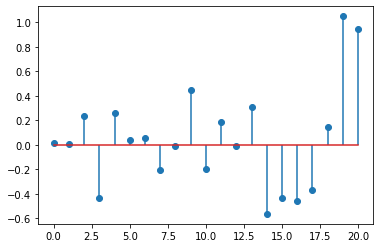

In [177]:
w = np.linalg.inv(R) @ pxd
# w = shrink(w, 50)
plt.stem(w[:50])

In [178]:
from mvdr.filter import apply_mvdr

y = apply_mvdr(x, w)
y.shape

(1, 300)

(0.986217424015353, 6.865535697667322e-235)
0.9376842757312974


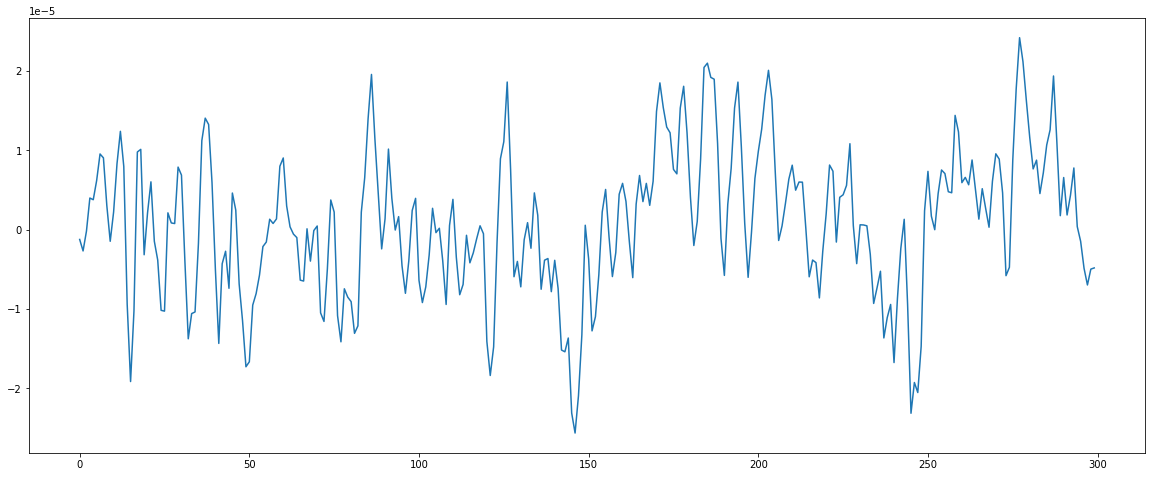

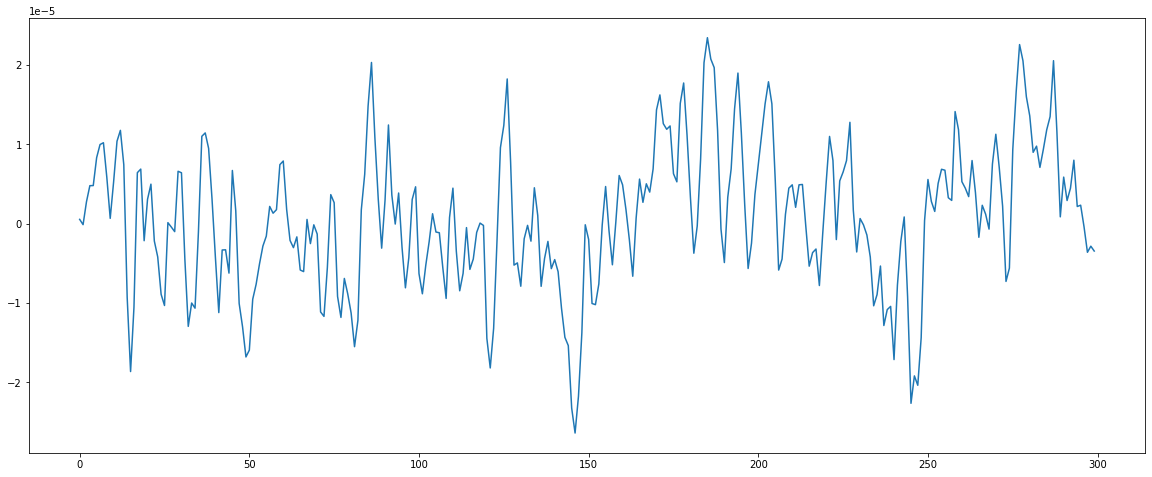

In [179]:
from scipy.stats import pearsonr
print(
    pearsonr(
        d[0],
        y[0]
    )
)
print(
    np.max(
        [
            pearsonr(
                c,
                d[0]
            )[0]
            for c in x
        ]
    )
)
plt.figure(figsize=(20, 8))
plt.plot(d[0])
plt.figure(figsize=(20, 8))
plt.plot(y[0])


(0.986277935268106, 3.58006184655324e-235)


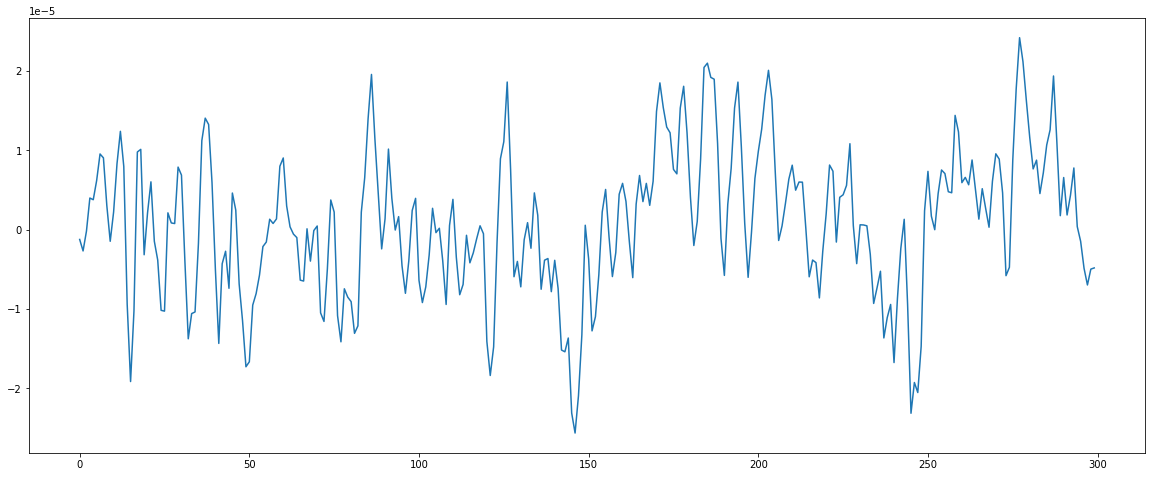

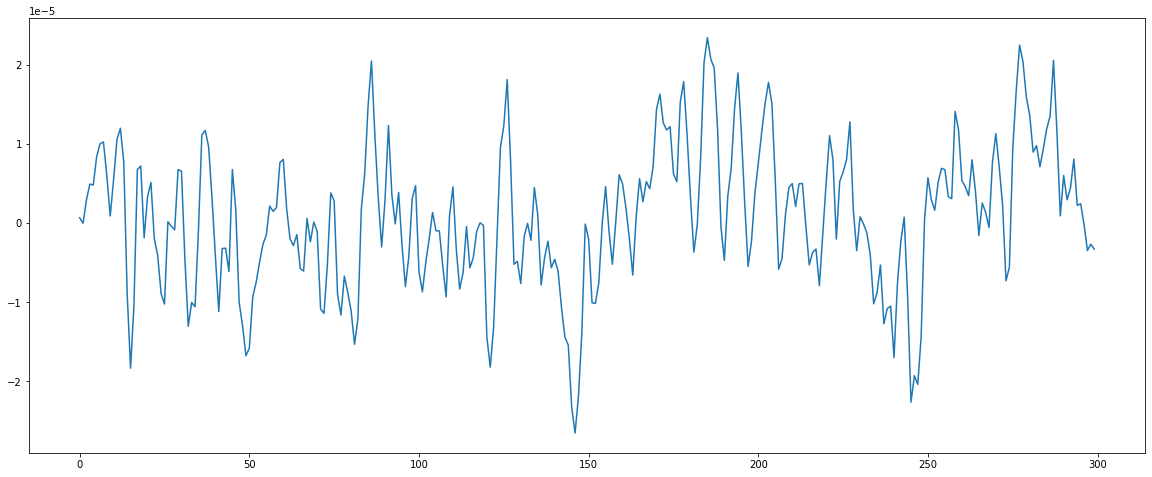

In [158]:
from sklearn.linear_model import LinearRegression

olr = LinearRegression().fit(x.T, d.T)
y = olr.predict(x.T)

plt.figure(figsize=(20, 8))
plt.plot(d.T)
plt.figure(figsize=(20, 8))
plt.plot(y)

print(
    pearsonr(
        d.flatten(),
        y.flatten()
    )
)

In [87]:
d.T.shape, y.T.shape

((300, 1), (1, 300))

In [4]:
cues = np.unique(epochs_list[0].events[:, 2])

In [5]:
e = epochs_list[0]
print(metadata_list[0])

{'id': 'A01', 'smoking': 'Yes', 'alcohol_abuse': 'Unknown', 'drug_abuse': 'Unknown', 'medication': 'Unknown', 'weight': None, 'height': None, 'sex': 'Female', 'handedness': 'Right', 'age': 39}


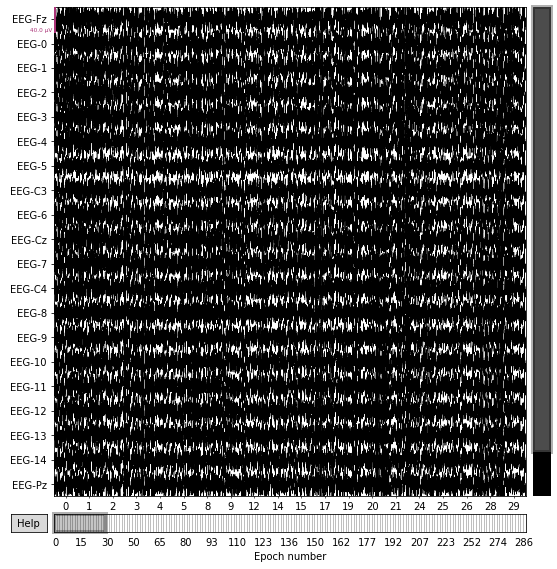

In [6]:
e.plot();

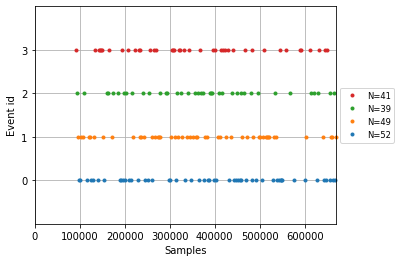

In [7]:
mne.viz.plot_events(epochs_list[0].events);

In [8]:
e.ch_names

['EEG-Fz',
 'EEG-0',
 'EEG-1',
 'EEG-2',
 'EEG-3',
 'EEG-4',
 'EEG-5',
 'EEG-C3',
 'EEG-6',
 'EEG-Cz',
 'EEG-7',
 'EEG-C4',
 'EEG-8',
 'EEG-9',
 'EEG-10',
 'EEG-11',
 'EEG-12',
 'EEG-13',
 'EEG-14',
 'EEG-Pz',
 'EEG-15',
 'EEG-16']

In [9]:
from statsmodels.tsa.stattools import acf

L_FREQ, H_FREQ = (None, 40)
RE_FS = 100

def multi_trial_acf(x, nlags=100):
    autocorr_sequence = 0
    for trial_number in range(len(x)):
        autocorr_sequence += acf(x[trial_number], nlags=nlags)
    return autocorr_sequence / len(x)

def multi_person_acf(x_list, nlags=100):
    autocorr_sequence = 0
    for x in x_list:
        autocorr_sequence += multi_trial_acf(x, nlags=nlags)
    return autocorr_sequence

def multi_person_acf_from_epochs(epochs, channel, cue=None, nlags=100):
    autocorr_sequence = 0
    for epoch in epochs:
        loaded_epochs = epoch.copy().load_data().filter(l_freq=L_FREQ, h_freq=H_FREQ).resample(RE_FS)
        if cue is not None:
            assert cue in np.unique(loaded_epochs.events[:, 2])
            loaded_epochs = loaded_epochs.drop(loaded_epochs.events[:, 2] != cue)
        channel_idx = loaded_epochs.ch_names.index(channel)
        data = loaded_epochs.get_data()
        autocorr_sequence += multi_trial_acf(
            data[:, channel_idx, :],
            nlags=nlags
        )
    return autocorr_sequence

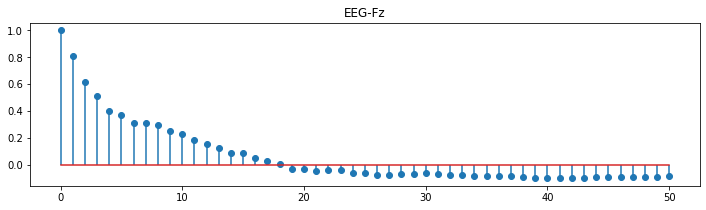

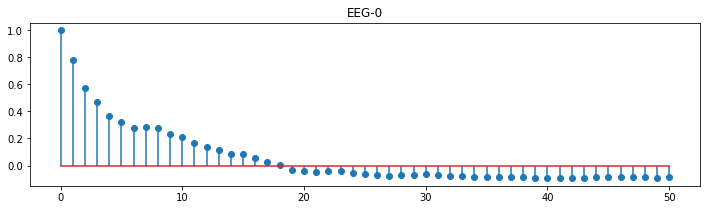

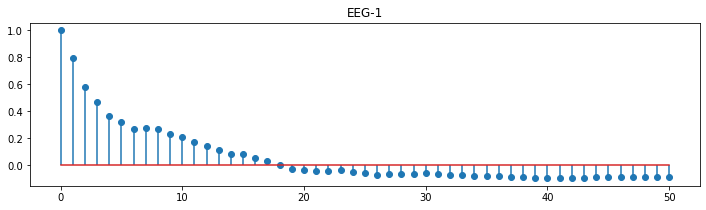

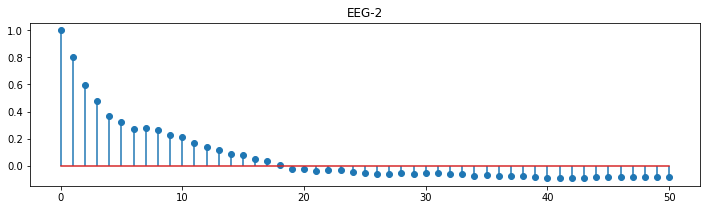

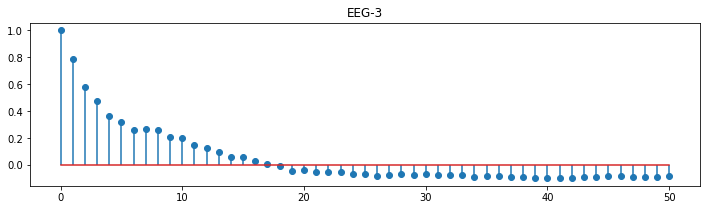

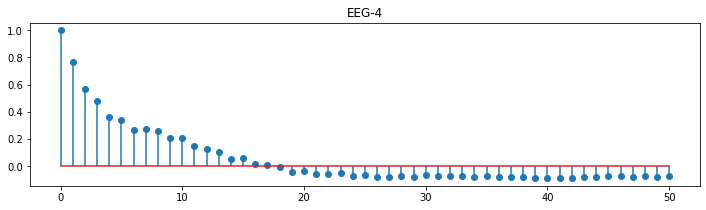

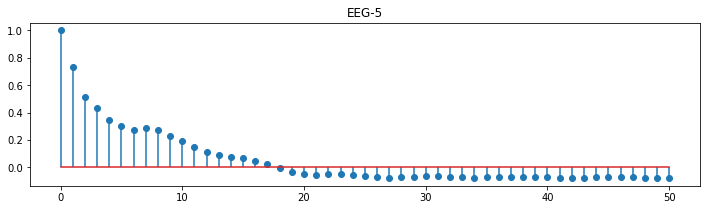

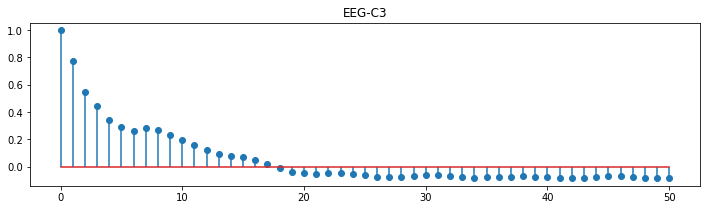

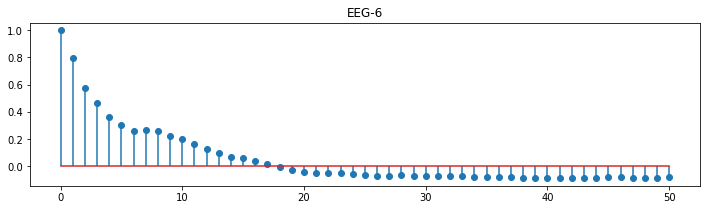

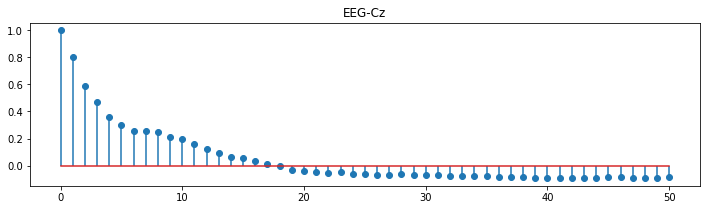

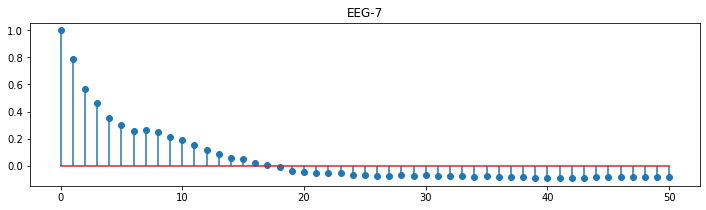

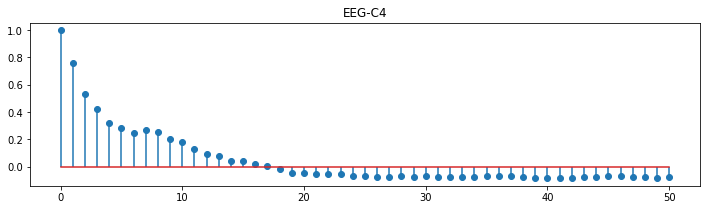

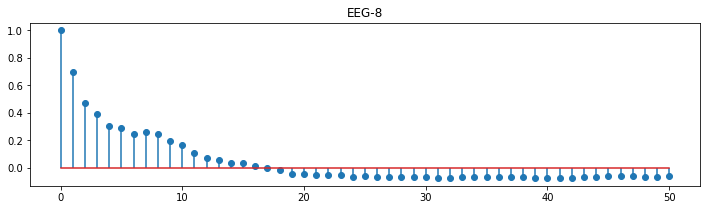

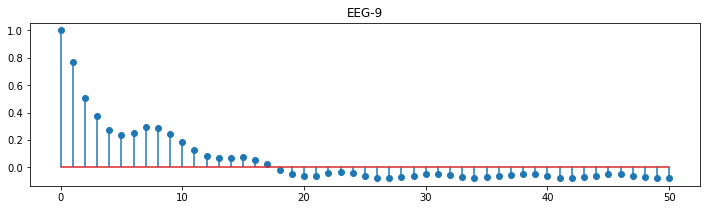

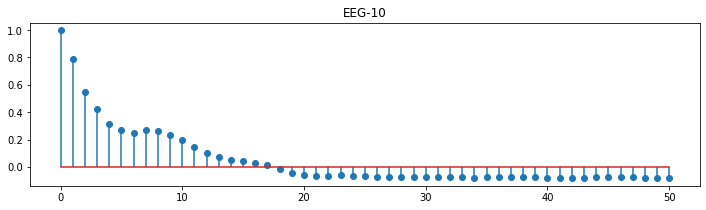

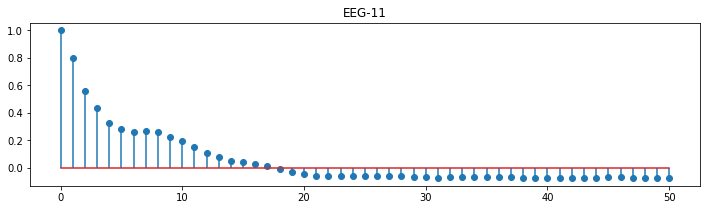

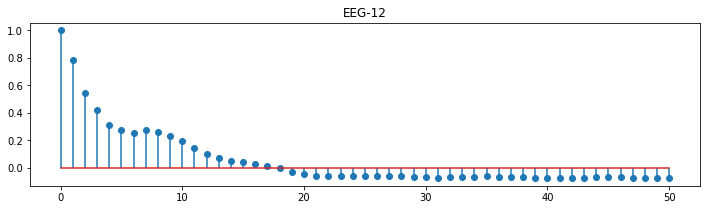

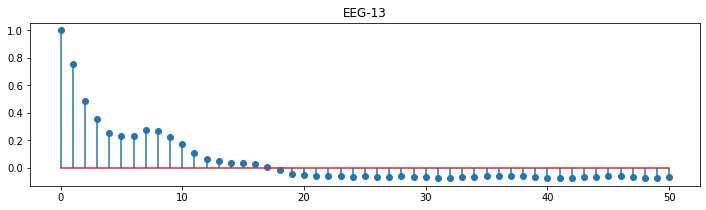

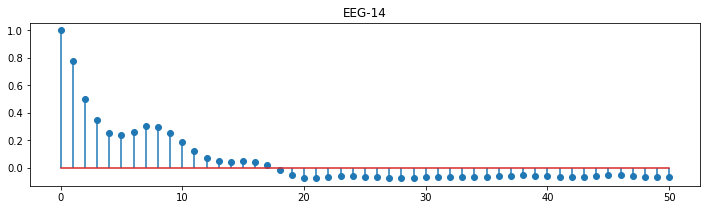

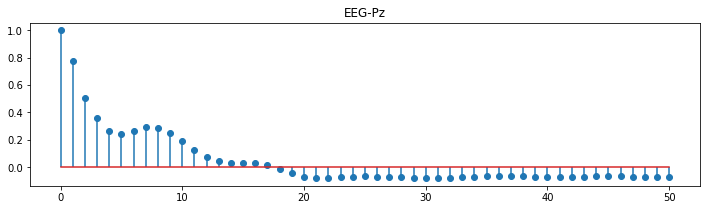

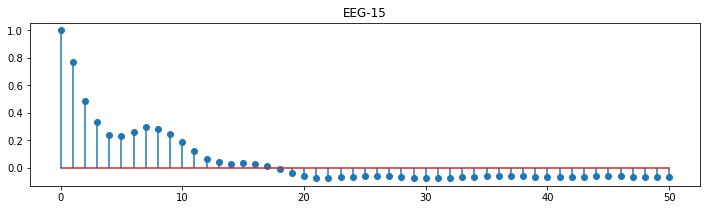

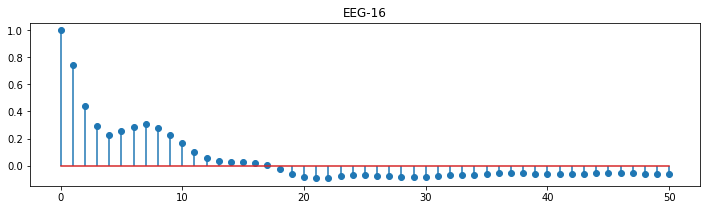

In [10]:
from ica_benchmark.processing.ica import get_ica_instance, get_all_methods

channels = e.copy().load_data().filter(l_freq=None, h_freq=40).resample(90.)
data = channels.get_data()
for i in range(len(channels.ch_names)):
    x = data[:, i, :]
#     print(shapiro())
    plt.figure(figsize=(12, 3))
    plt.stem(multi_trial_acf(x, nlags=50))
    plt.title(channels.ch_names[i])
    plt.show()
    

In [11]:
selected_channels = ["EEG-Fz", "EEG-C3", "EEG-C4", "EEG-Pz", "EEG-Cz"]

In [ ]:
nrows, ncols = len(selected_channels), len(cues), 
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 2), sharey=True, sharex=True)
for col, cue in enumerate(cues):
    for row, channel in enumerate(selected_channels):
        autocorr_sequence = multi_person_acf_from_epochs(
            imagery_epochs_list,
            channel,
            cue=cue,
            nlags=30
        )
        ax = axes[row, col]
        ax.stem(autocorr_sequence)
        ax.set_title(f"{channel} - {cue}")
plt.show()

In [12]:
from ica_benchmark.processing.ica import get_ica_instance
ICA = get_ica_instance("sobi", n_components=len(epochs_list[0].ch_names))
ICA.fit(concatenated_imagery_epochs_list)

example_sources = ICA.get_sources(imagery_epochs_list[0])
ica_channels = example_sources.ch_names

imagery_sources_epochs_list = [
    ICA.get_sources(epochs)
    for epochs
    in imagery_epochs_list
]

In [ ]:
nrows, ncols = len(ica_channels), len(cues), 
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 2), sharey=True, sharex=True)
for col, cue in enumerate(cues):
    for row, channel in enumerate(ica_channels):
        autocorr_sequence = multi_person_acf_from_epochs(
            imagery_sources_epochs_list,
            channel,
            cue=cue,
            nlags=30
        )
        ax = axes[row, col]
        ax.stem(autocorr_sequence)
        ax.set_title(f"{channel} - {cue}")
plt.show()
    


In [ ]:
def psd_from_epoch(epoch, channel, cue=None, mean=True):
    if cue is not None:
        epoch = epoch.copy().drop(epoch.events[:, 2] != cue)
    psd, freqs = mne.time_frequency.psd_multitaper(
        epoch,
        fmin=0,
        fmax=30,
        tmin=None,
        tmax=None,
        bandwidth=None,
        adaptive=False,
        low_bias=True,
        normalization='length',
        picks=channel,
        proj=False,
        n_jobs=3,
        reject_by_annotation=False,
        verbose=None
    )
    
    psd = psd.squeeze()
    if mean:
        psd = psd.mean(axis=0, keepdims=True)
    return psd, freqs

def multi_person_psd_from_epochs(epochs, channel, cue=None, mean=False):
    # (n_epochs, n_channels, n_freqs)
    psd_list = list()
    for epoch in epochs:
        psd, freqs = psd_from_epoch(
            epoch,
            channel,
            cue=cue,
            mean=mean
        )
        psd_list.append(psd)
        
    psd_arr = np.concatenate(psd_list, axis=0)
    mean_psd = psd_arr.mean(axis=0)
    std_psd = psd_arr.std(axis=0)
    return mean_psd, std_psd, freqs


In [ ]:
from scipy.signal import find_peaks

def axvlines(ax, x_list, y_min_list, y_max_list):
    for x, y_min, y_max in zip(x_list, y_min_list, y_max_list):
        ax.axvline(x, y_min, y_max)

In [ ]:
from scipy.signal import find_peaks

nrows, ncols = len(selected_channels), len(cues), 
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 3), sharey=True, sharex=True)
for col, cue in enumerate(cues):
    for row, channel in enumerate(selected_channels):
        psd, err, freqs = multi_person_psd_from_epochs(
            imagery_epochs_list,
            channel,
            cue=cue,
        )
        peaks, _ = find_peaks(psd)
        ax = axes[row, col]
        ax.plot(freqs, psd)
        ax.fill_between(freqs, psd - err, psd + err, alpha=.3)
#         axvlines(ax, freqs[peaks], psd[peaks] - err[peaks], psd[peaks] + err[peaks])
        ax.set_title(f"{channel} - {cue}")
        ax.grid()
plt.tight_layout()
plt.show()

In [ ]:
nrows, ncols = len(ica_channels), len(cues), 
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 3), sharey=False, sharex=True)
for col, cue in enumerate(cues):
    for row, channel in enumerate(ica_channels):
        psd, err, freqs = multi_person_psd_from_epochs(
            imagery_sources_epochs_list,
            channel,
            cue=cue,
        )
        peaks, _ = find_peaks(psd)
        ax = axes[row, col]
        ax.plot(freqs, psd)
        ax.fill_between(freqs, psd - err, psd + err, alpha=.3)
#         axvlines(ax, freqs[peaks], psd[peaks] - err[peaks], psd[peaks] + err[peaks])
        ax.set_title(f"{channel} - {cue}")
        ax.grid()
plt.tight_layout()
plt.show()


In [ ]:
nrows, ncols = len(ica_channels), len(cues), 
fig, axes = plt.subplots(nrows, ncols * 2, figsize=(ncols * 5, nrows * 3), sharey=False, sharex=True)
for col, cue in enumerate(cues):
    for row, channel in enumerate(ica_channels):
        psd, err, freqs = multi_person_psd_from_epochs(
            imagery_sources_epochs_list,
            channel,
            cue=cue,
        )
        peaks, _ = find_peaks(psd)
        ax = axes[row, col]
        ax.plot(freqs, psd)
        ax.fill_between(freqs, psd - err, psd + err, alpha=.3)
#         axvlines(ax, freqs[peaks], psd[peaks] - err[peaks], psd[peaks] + err[peaks])
        ax.set_title(f"{channel} - {cue}")
        ax.grid()
plt.tight_layout()
plt.show()


In [ ]:
from ica_benchmark.scoring import SCORING_FN_DICT
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from functools import partial

if "coherence" in SCORING_FN_DICT:
    SCORING_FN_DICT.pop("coherence")
SCORING_FN_DICT["pearsonr"] = lambda a, b: pearsonr(a, b)[0]

def apply_fn(vecs, fn):
    n = len(vecs)
    matrix = np.empty((n, n))
    for row in range(n):
        for col in range(n):
            matrix[row, col] = fn(vecs[row], vecs[col])
    return matrix

def avg_apply_fn(vecs, fn):
    m = 0
    for vec in vecs:
        m += apply_fn(vec, fn=fn)
    return m / len(vecs)

nrows, ncols = len(SCORING_FN_DICT), len(cues), 
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3), sharey=False, sharex=False)
for col, cue in enumerate(cues):
    data = [
        epoch.copy().drop(epoch.events[:, 2] != cue).get_data().transpose(1, 0, 2).reshape(22, -1)
        for epoch
        in imagery_epochs_list[:1]
    ]
    for row, (scoring_name, scoring_fn) in enumerate(SCORING_FN_DICT.items()):
        m = avg_apply_fn(
            data,
            scoring_fn
        )
        ax = axes[row, col]
        im = ax.imshow(np.round(m, 5))
        ax.set_title(f"{scoring_name} - {cue}")
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar = fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout()
plt.show()




In [ ]:
nrows, ncols = len(SCORING_FN_DICT), len(cues), 
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3), sharey=False, sharex=False)
for col, cue in enumerate(cues):
    data = [
        epoch.copy().drop(epoch.events[:, 2] != cue).get_data().transpose(1, 0, 2).reshape(22, -1)
        for epoch
        in imagery_sources_epochs_list
    ]
    for row, (scoring_name, scoring_fn) in enumerate(SCORING_FN_DICT.items()):
        m = avg_apply_fn(
            data,
            scoring_fn
        )
        ax = axes[row, col]
        im = ax.imshow(np.round(m, 5))
        ax.set_title(f"{scoring_name} - {cue}")
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar = fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KernelDensity

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec

data = pd.read_csv("/home/paulo/Downloads/mock-european-test-results.csv")

colors = ['#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000']



def cue_to_name(cue):
    return {
        0: "Left hand",
        1: "Right hand",
        2: "Foot",
        3: "Tongue",
    }[cue]

def plot_cue_stems(data_list, title="", title_list=None, orig_ax=None):
    if orig_ax is None:
        fig = plt.figure(figsize=(16, 9))
        gs = grid_spec.GridSpec(len(cues), 1)
    else:
        divider = make_axes_locatable(orig_ax)            
        
    for i, cue in enumerate(cues):
        if orig_ax is None:
            ax = fig.add_subplot(gs[i:i+1, 0:])
        else:
            if i == 0:
                ax = orig_ax
                ax.set_title(title)
            else:
                ax = divider.new_vertical(size="100%", pad=0.1, pack_start=True)
                orig_ax.get_figure().add_axes(ax)

        ax.stem(data_list[i])
        ax.set_ylim(-0.3, 1)

        rect = ax.patch
        rect.set_alpha(0)

        ax.set_yticklabels([])
        
        ax.grid()
        
        if i == len(cues) - 1:
            ax.set_xlabel("Lag", fontsize=16,fontweight="bold")
        else:
            ax.set_xticklabels([])

        spines = ["top","right","left","bottom"]
        for s in spines:
            ax.spines[s].set_visible(False)
        
        if title_list is not None:
            ax.text(-0.2, 0, cue_to_name(cue), fontweight="bold", fontsize=14, ha="right")
#             ax.text(-0.2, 0, title_list[i], fontweight="bold", fontsize=14, ha="right")

    if orig_ax is None:
        gs.update(hspace=-.0)
    
    
    fig.text(0.5, 1, "Cross-correlation coefficients", fontsize=20, horizontalalignment="center")
    
#     plt.tight_layout()
#     plt.show()
    
fig, axes = plt.subplots(1, 3)
plots_cue_stems(
    ([1,2,3],
    [1,2,3],
    [1,2,3],
    [1,2,3]),
    title_list=[1, 2, 3, 4],
    orig_ax=axes[2]
)

In [ ]:
from statsmodels.tsa.stattools import ccf

L_FREQ, H_FREQ = (None, 40)
RE_FS = 100

def multi_trial_ccf(x, y, nlags=100):
    crosscorr_sequence = 0
    assert len(x) == len(y)
    
    for trial_number in range(len(x)):
        crosscorr_sequence += ccf(x[trial_number], y[trial_number])
    return crosscorr_sequence[:nlags] / len(x)

def multi_person_ccf(x_list, nlags=100):
    crosscorr_sequence = 0
    for x in x_list:
        crosscorr_sequence += multi_trial_ccf(x, nlags=nlags)
    return crosscorr_sequence

def multi_person_ccf_from_epochs(epochs, channel_a, channel_b, cue=None, nlags=100):
    crosscorr_sequence = 0
    for epoch in epochs:
        loaded_epochs = epoch.copy().load_data().filter(l_freq=L_FREQ, h_freq=H_FREQ).resample(RE_FS)
        if cue is not None:
            assert cue in np.unique(loaded_epochs.events[:, 2])
            loaded_epochs = loaded_epochs.drop(loaded_epochs.events[:, 2] != cue)
        
        data_a = loaded_epochs.copy().pick(channel_a).get_data().squeeze()
        data_b = loaded_epochs.copy().pick(channel_b).get_data().squeeze()
        
        crosscorr_sequence += multi_trial_ccf(
            data_a,
            data_b,
            nlags=nlags
        )
    return crosscorr_sequence


In [ ]:
n_channels = len(selected_channels)
for e_idx, epochs in enumerate(imagery_epochs_list):
    fig, axes = plt.subplots(n_channels, n_channels, figsize=(4 * n_channels, 6 * n_channels), dpi=100)
    sequences = list()
    for row, channel_1 in enumerate(selected_channels):
        for col, channel_2 in enumerate(selected_channels):
            if row > col:
                axes[row, col].axis(False)
                continue
            for cue in cues:
                e = (
                    epochs \
                    .copy() \
                    .drop(epochs.events[:, 2] != cue)
                    .load_data() \
                    .filter(l_freq=L_FREQ, h_freq=H_FREQ) \
                    .resample(RE_FS) \
                )
                s1 = e.pick(channel_1).get_data().squeeze()
                s2 = e.pick(channel_1).get_data().squeeze()
                crosscorr_sequence = multi_trial_ccf(s1, s2, nlags=50)
                sequences.append(crosscorr_sequence)

            ax = axes[row, col]
            plot_cue_stems(
                sequences,
                orig_ax=ax,
                title="[A{}]: {} x {}".format(
                    e_idx,
                    channel_1,
                    channel_2
                )
            )
    plt.show()

In [ ]:
x.shape

In [22]:
n = 1000000

Lasso(fit_intercept=False).fit(
    x, y
)


Lasso(fit_intercept=False)

In [48]:
data.shape

(47, 22, 751)

EEG-Fz 0.9398114452482034 7.48660849253602e-12
EEG-0 0.9874188194116644 1.0553165104534403e-12
EEG-1 0.9944682419297919 5.368689289078169e-13
EEG-2 0.9919305743104396 8.675327913330569e-13
EEG-3 0.9555884137640807 4.498222574290404e-12
EEG-4 0.9516880963525227 4.575370375692619e-12
EEG-5 0.8809895668810094 6.204109432136607e-12
EEG-C3 0.9936060812097863 4.449255350715064e-13
EEG-6 0.9904307068113222 8.285172583184001e-13
EEG-Cz 0.9927951242142062 7.140642252093906e-13
EEG-7 0.9924938574570277 6.943237022751593e-13
EEG-C4 0.9890442708363971 9.519995663373047e-13
EEG-8 0.924217717481096 5.740284805039552e-12
EEG-9 0.9898264602264858 6.729397857232487e-13
EEG-10 0.9956301232615113 3.363021972964797e-13
EEG-11 0.994164000885632 4.922613854369409e-13
EEG-12 0.9877614338739872 1.010652902557275e-12
EEG-13 0.9818699200683378 1.4411170355198301e-12
EEG-14 0.9872105037530744 8.496025534733802e-13
EEG-Pz 0.99280988427164 5.40589588636053e-13
EEG-15 0.9891132155102036 7.960879204147651e-13
EEG-16

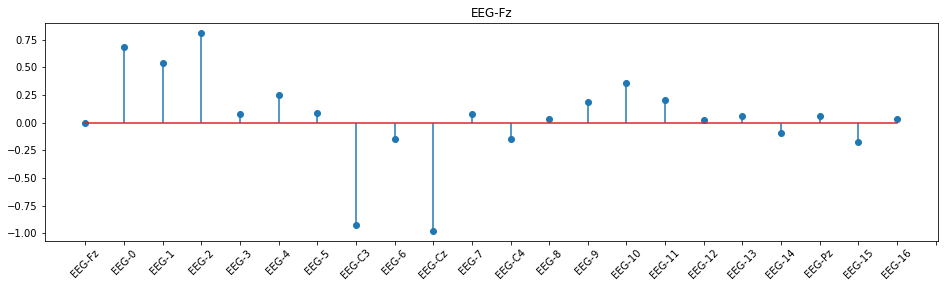

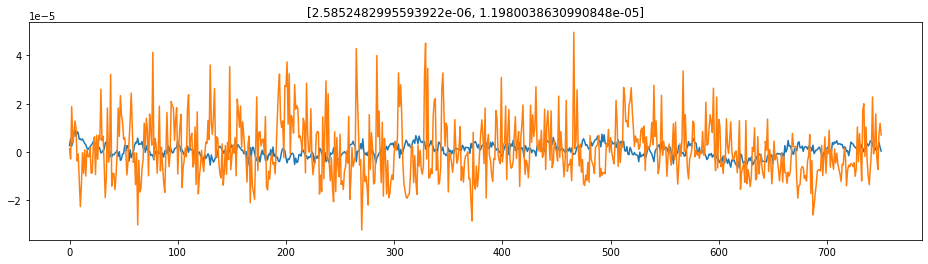

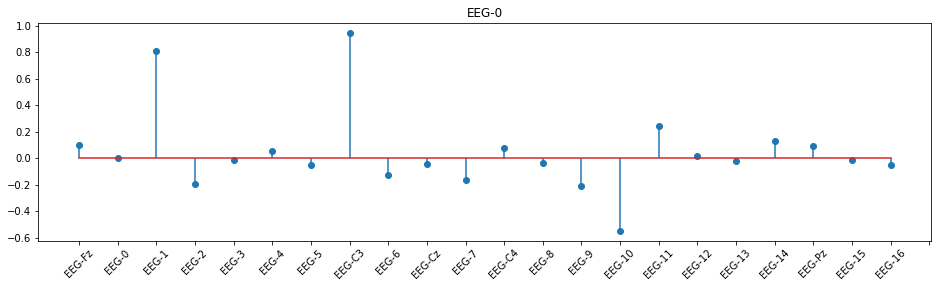

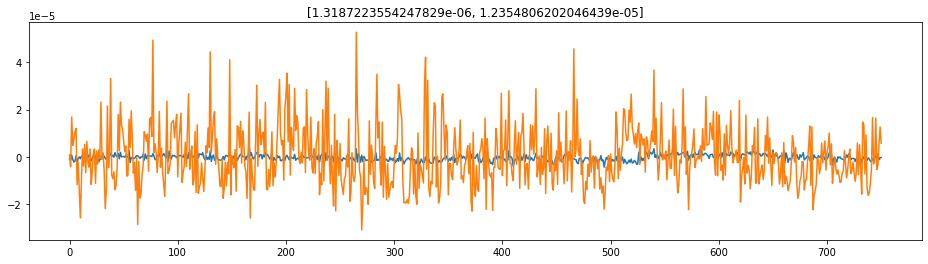

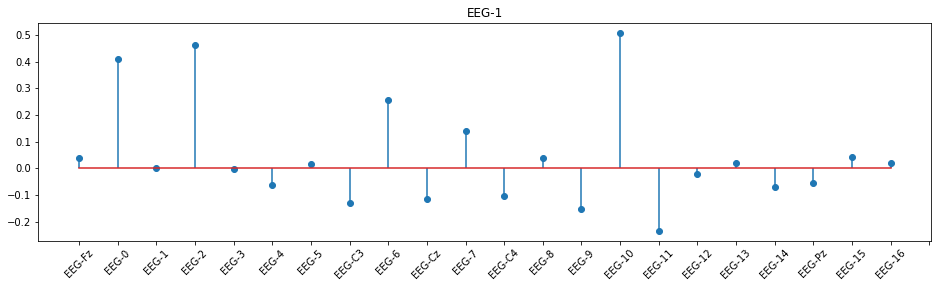

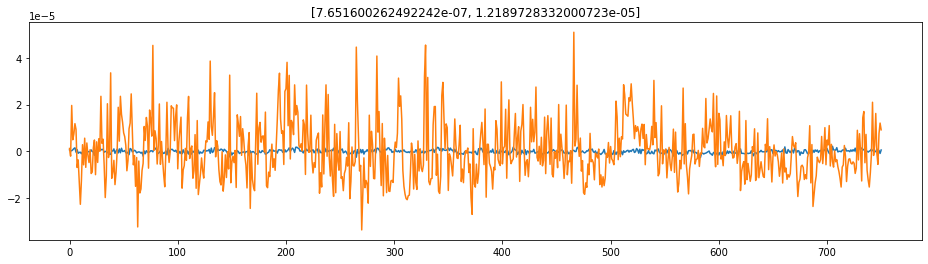

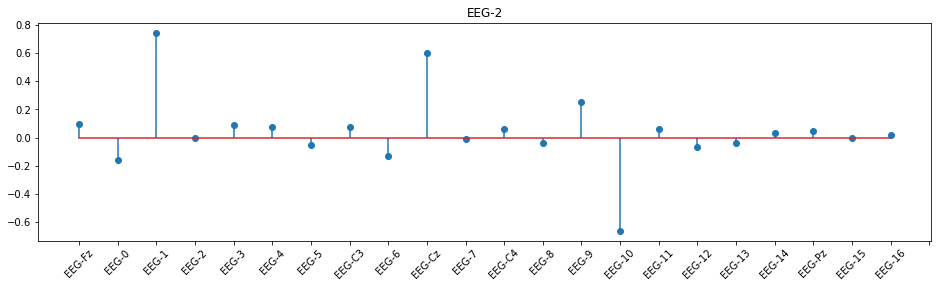

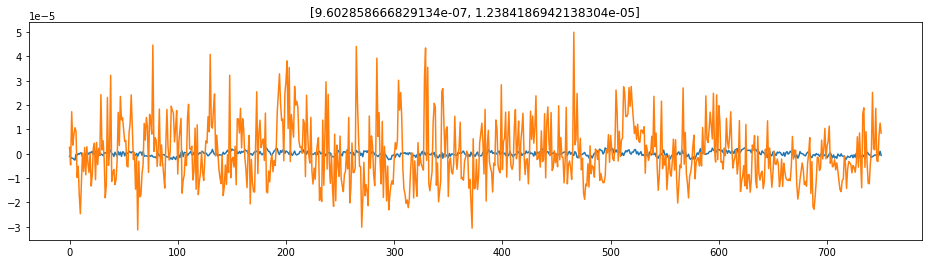

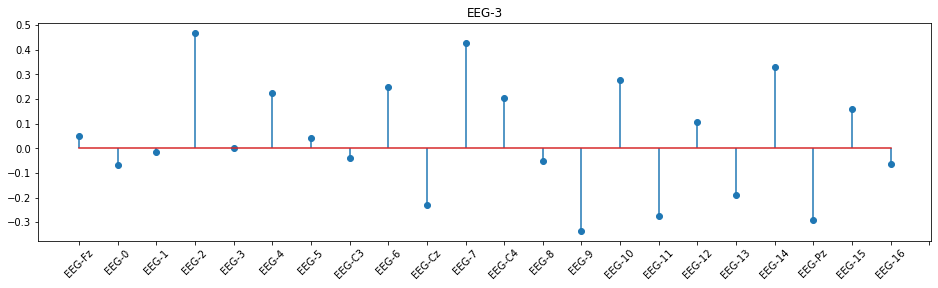

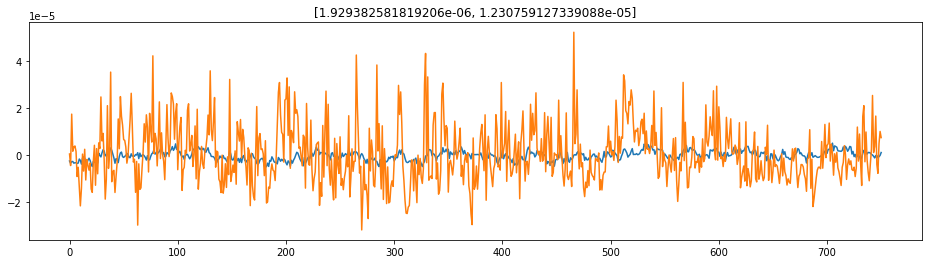

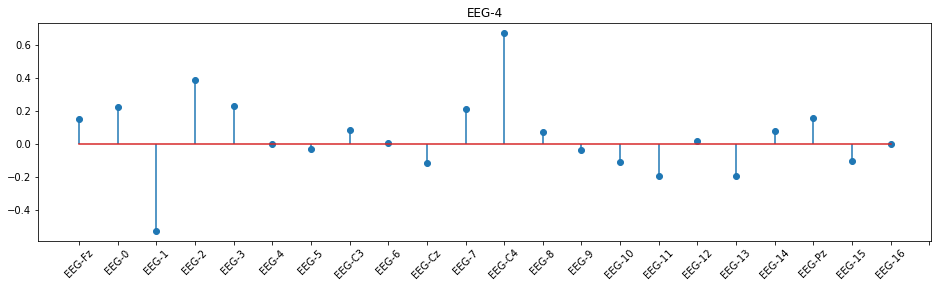

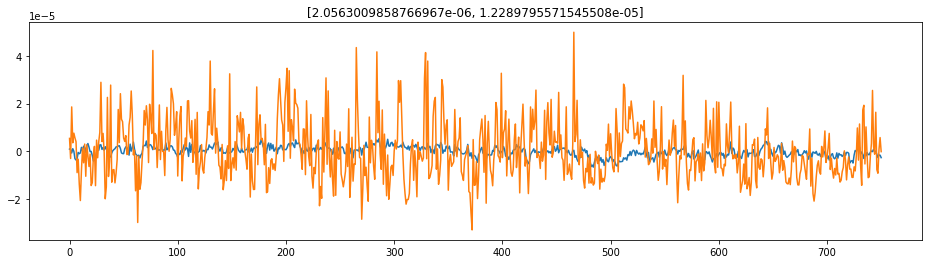

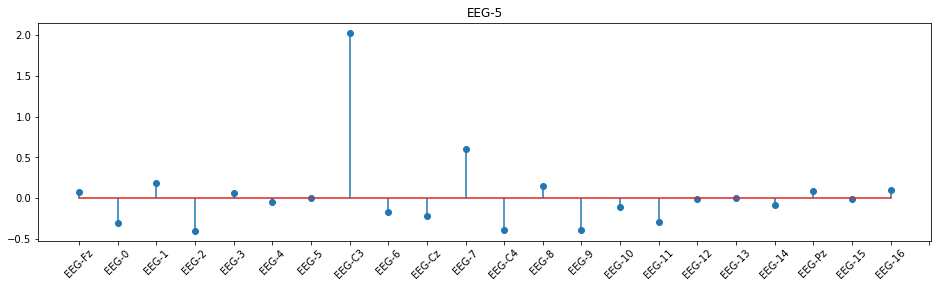

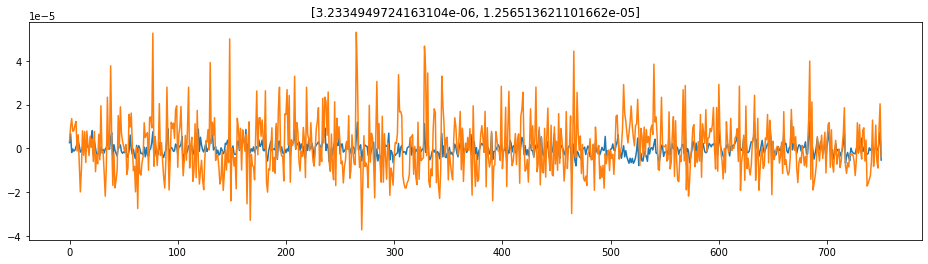

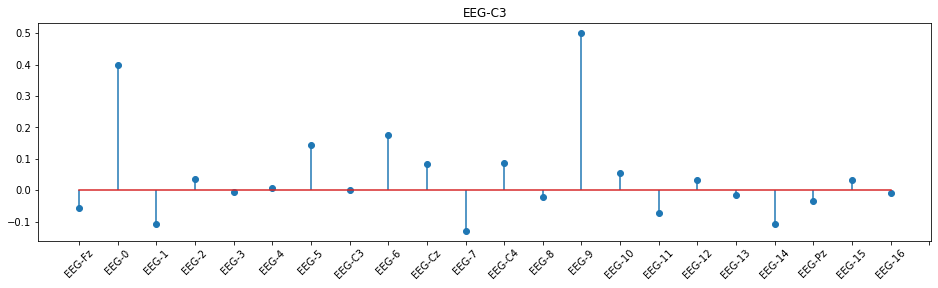

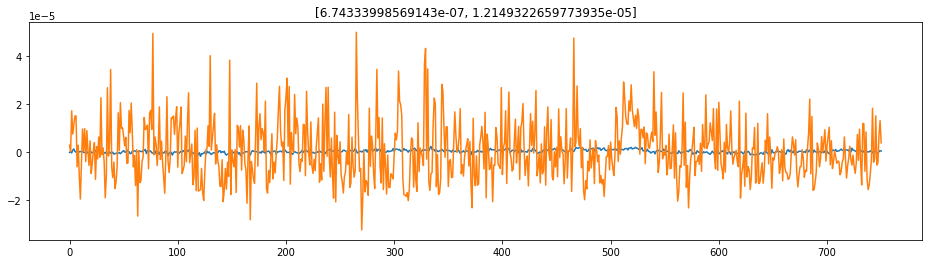

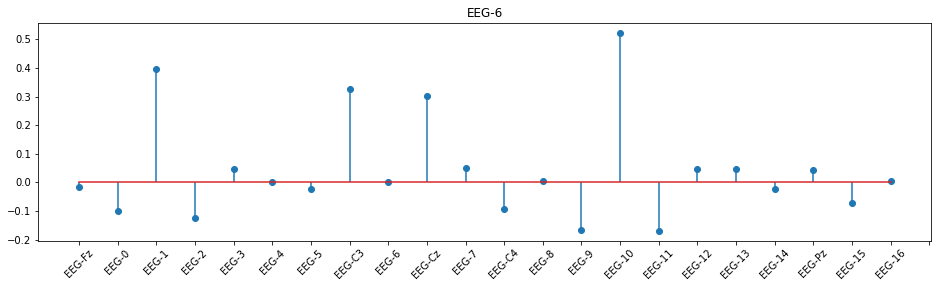

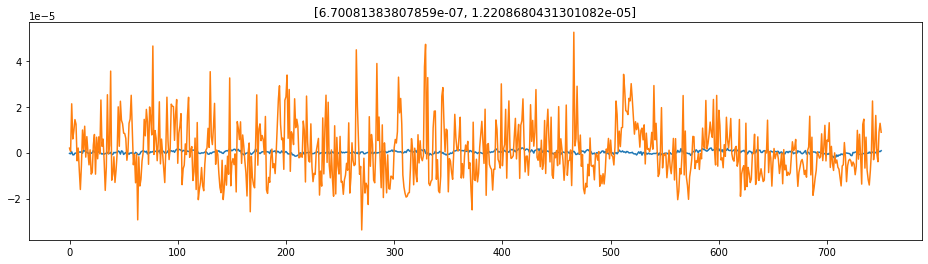

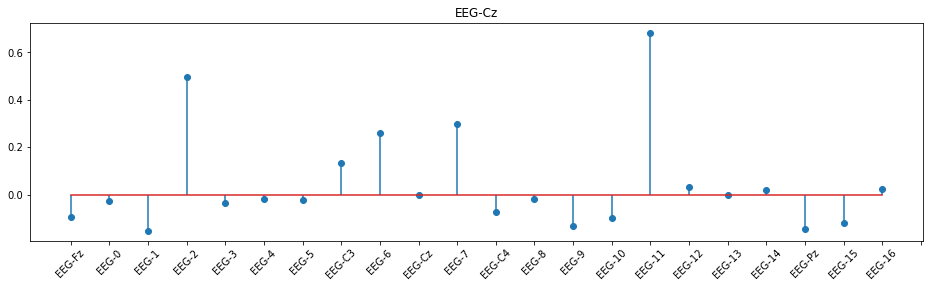

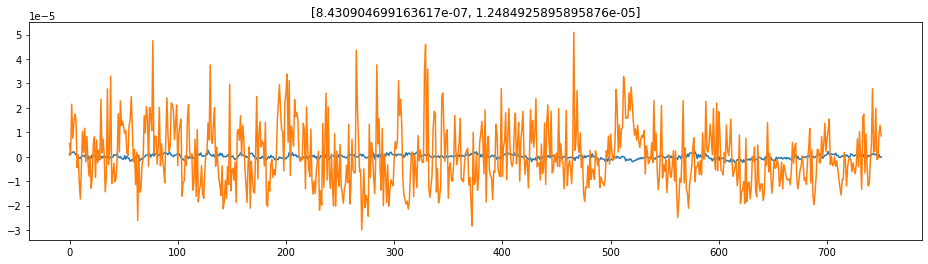

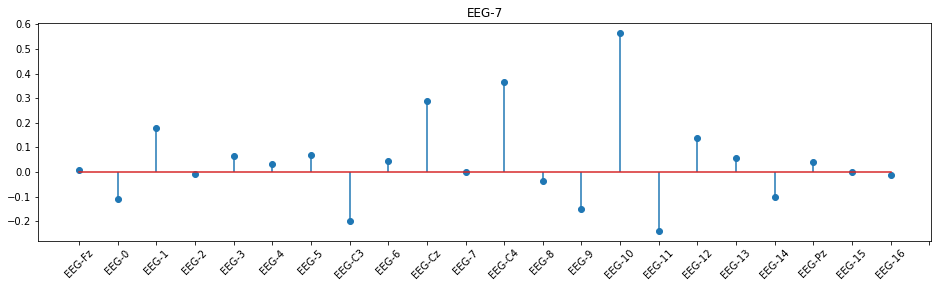

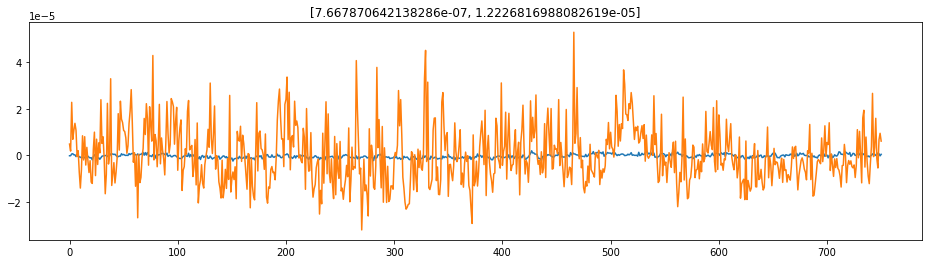

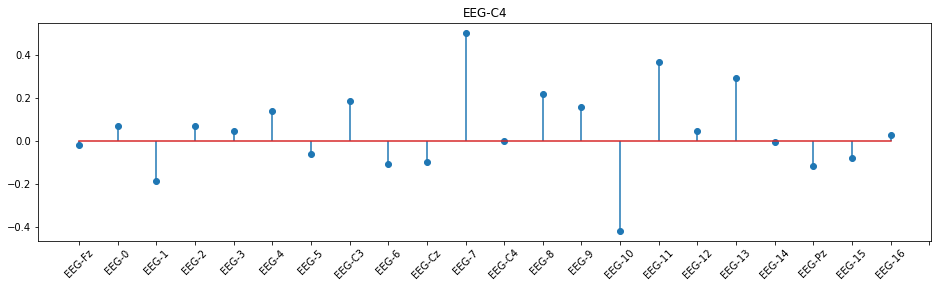

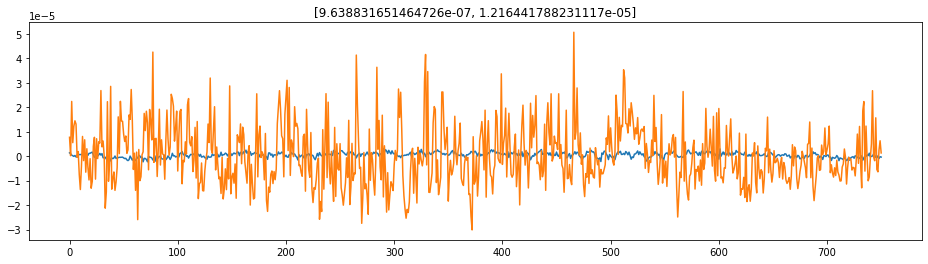

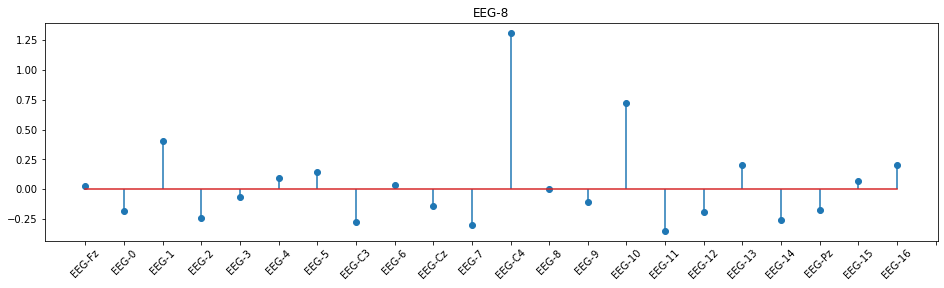

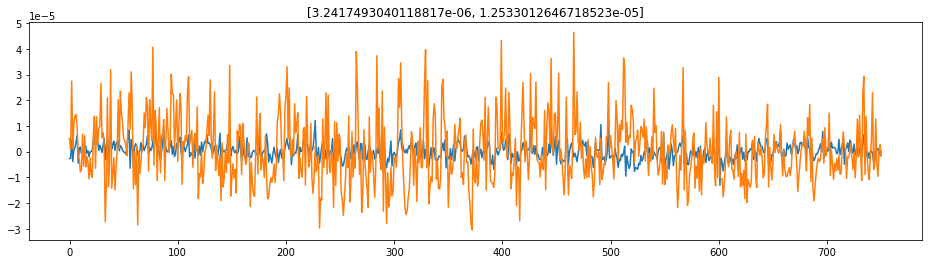

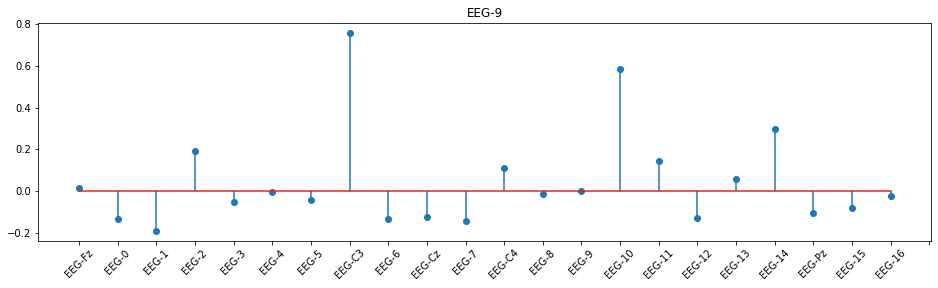

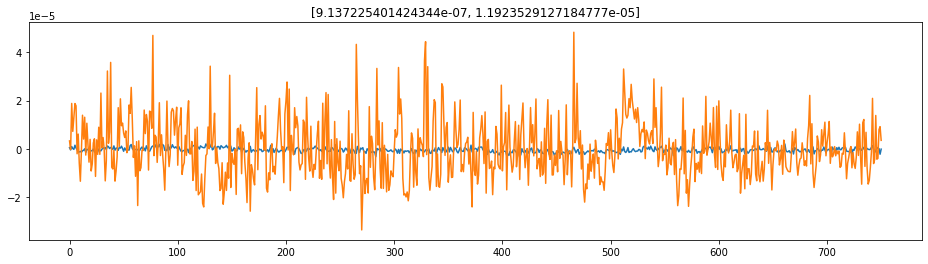

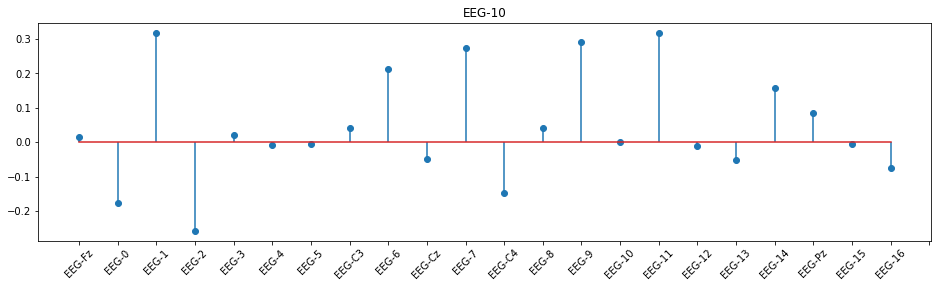

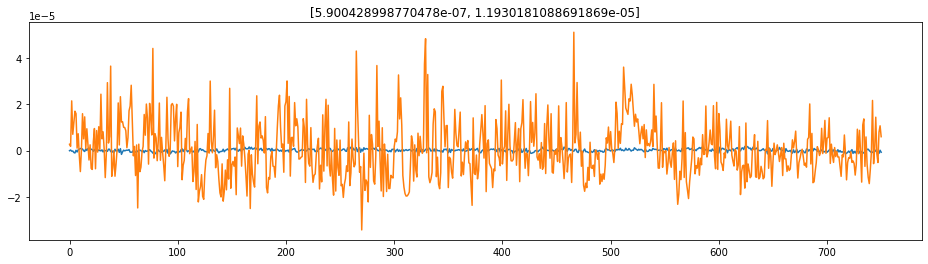

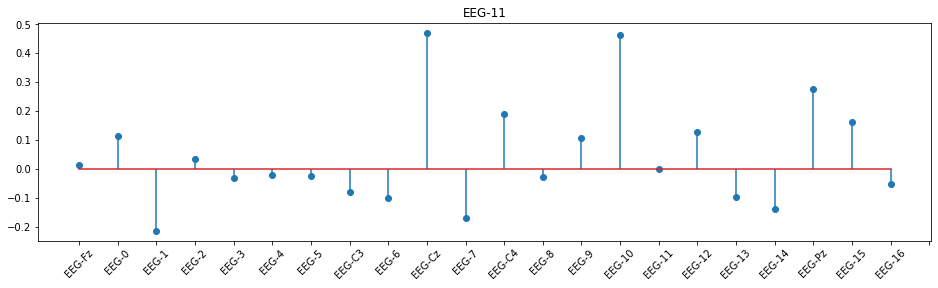

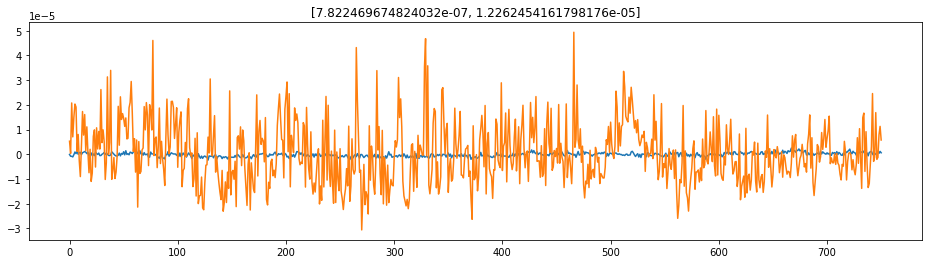

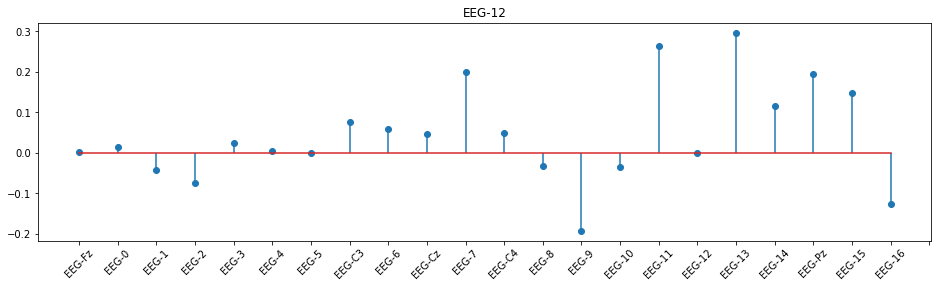

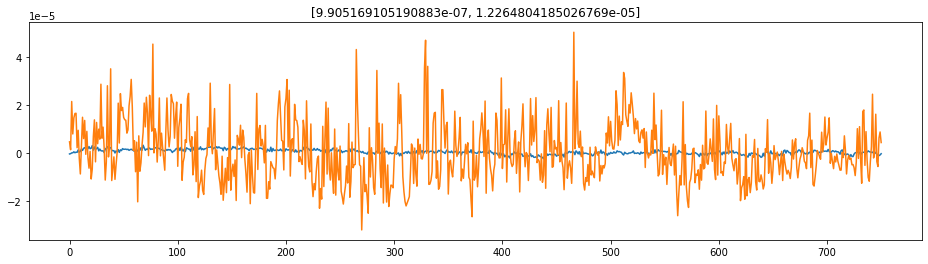

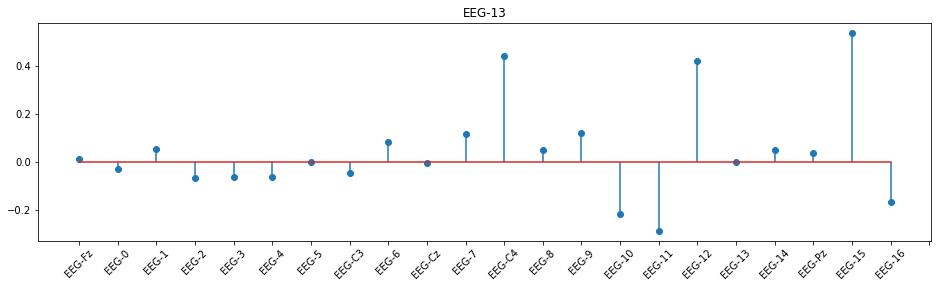

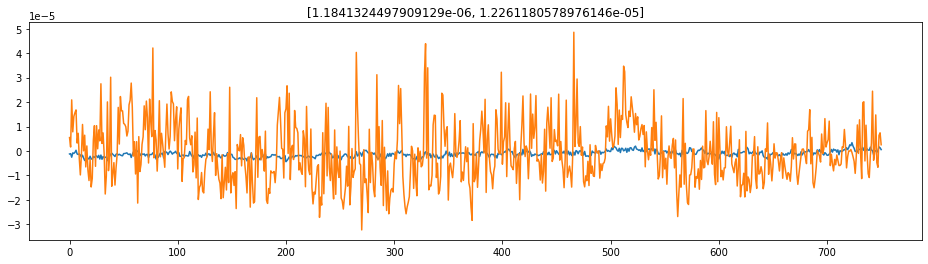

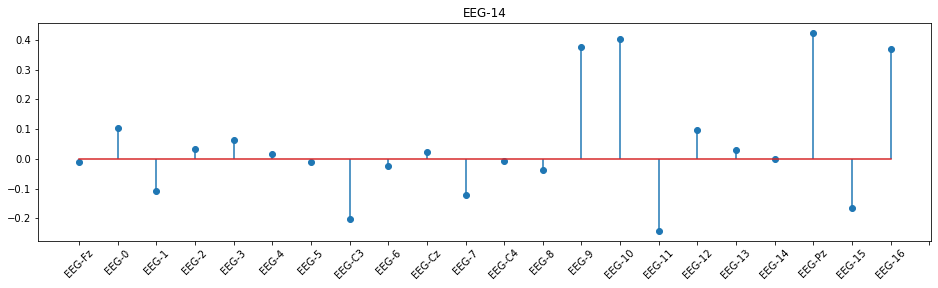

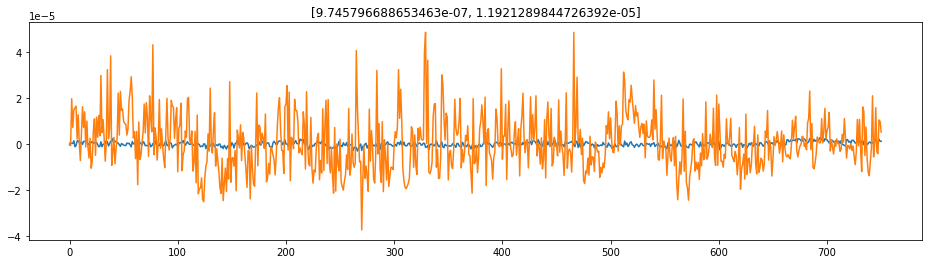

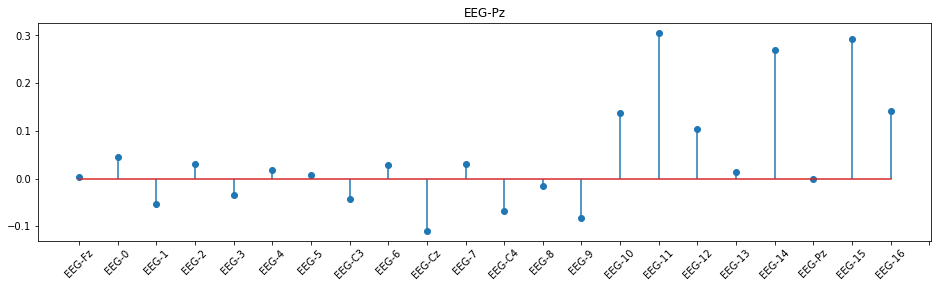

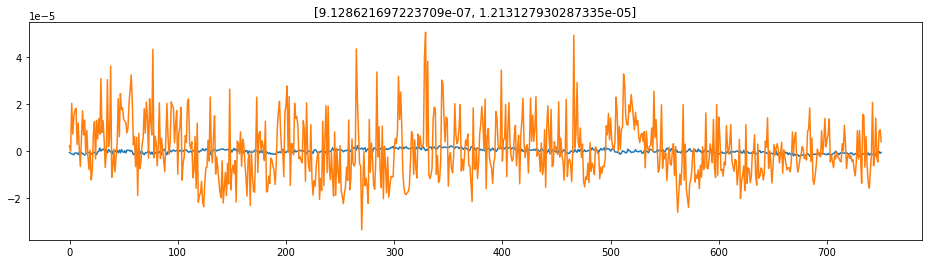

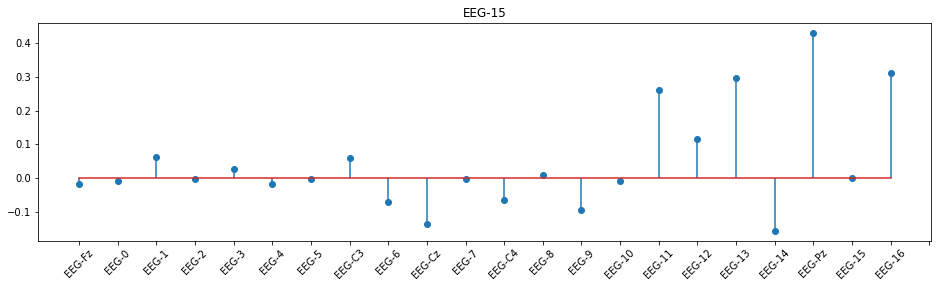

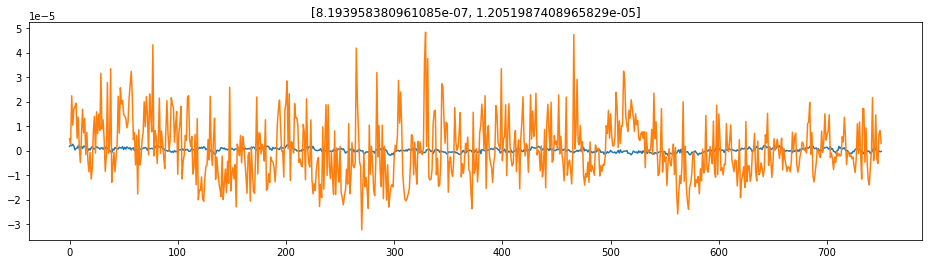

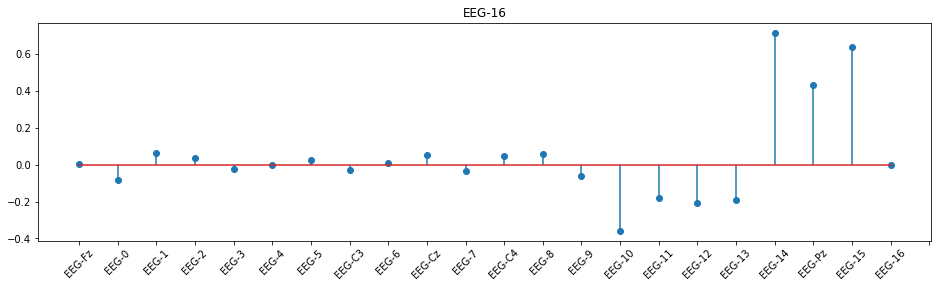

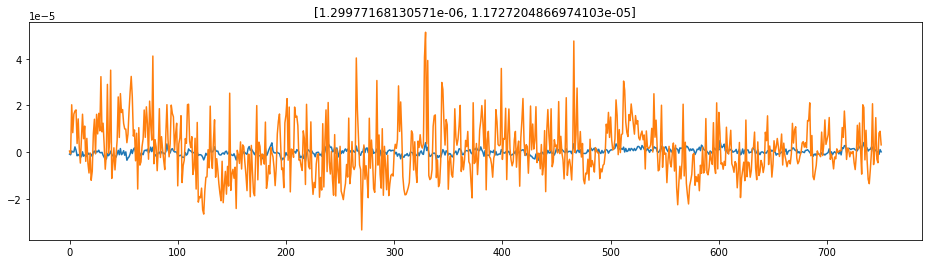

In [50]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_squared_error

data = imagery_epochs_list[1].copy().get_data()
ch_names = imagery_epochs_list[0].ch_names
models = dict()
filtered_signals = dict()
for c_idx in range(22):
    x_channels = list(range(22))
    x_channels.remove(c_idx)
#     olr = Lasso(fit_intercept=False, alpha=1e-10)
    olr = LinearRegression(fit_intercept=False)
    x = data[:, x_channels, :]
    y = data[:, [c_idx], :]
    x = x.transpose(1, 0, 2).reshape(21, -1).T
    y = y.transpose(1, 0, 2).reshape(1, -1).T
    olr.fit(x, y)
    pred = olr.predict(x).reshape(-1, 1)
    models[c_idx] = olr
    filtered_signals[c_idx] = y - pred
    print(ch_names[c_idx], r2_score(pred, y), mean_squared_error(pred, y))

for i in range(22):
    m = models[i]
    plt.figure(figsize=(16, 4))
    plt.title(ch_names[i])
    coefs = list(m.coef_.flatten())
    coefs = coefs[:i] + [0] + coefs[i:]
    plt.stem(ch_names, coefs)
    plt.xticks(range(23), rotation=45)
    plt.show()
    f = filtered_signals[i][:751]
    s = data[0, i, :]
    plt.figure(figsize=(16, 4))
    plt.title([f.std(), s.std()])
    plt.plot(f, label="Filtered")
    plt.plot(s, label="Signal")
#     plt.ylim(-5, 5)
    plt.show()


In [55]:
e = imagery_epochs_list[1]
# mne.get_montage_volume_labels(e)
mne.channels.make_1020_channel_selections(e.info)

{'Left': [2, 4, 6, 7, 10, 13, 15, 17, 20],
 'Midline': [0, 9, 19],
 'Right': [1, 3, 5, 8, 11, 12, 14, 16, 18, 21]}

In [74]:
e2.set
mne.create_info(
    [str(i) for i in range(22)],
    e2.info["sfreq"]
)

AttributeError: 'Info' object has no attribute 'set_channel_types'

In [72]:
e2.info

<Info | 8 non-empty values
 bads: []
 ch_names: EEG-Fz, EEG-0, EEG-1, EEG-2, EEG-3, EEG-4, EEG-5, EEG-C3, EEG-6, ...
 chs: 22 EEG
 custom_ref_applied: False
 dig: 3 items (3 Cardinal)
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 2004-11-15 12:00:00 UTC
 nchan: 22
 projs: []
 sfreq: 250.0 Hz
>

In [62]:
e2 = e.copy().set_montage(
    mne.channels.make_standard_montage("standard_1020"),
    on_missing="warn"
)
e2.plot_topo_image()

RuntimeError: Did not find any digitization points of kind FIFFV_POINT_EEG (3) in the info.

In [24]:
y.shape, pred.shape

((144192, 1), (144192,))

ICA000 0.9999931679923657 5.4060881628370395e-06
ICA001 0.9999971694057282 2.328762252626419e-06
ICA002 0.6033378784073034 0.24548557021844586
ICA003 0.999998729721074 1.0117009218871584e-06
ICA004 0.9999275538906243 5.7180309147260706e-05
ICA005 0.9980005009469972 0.001737772796008654
ICA006 0.9988222043318262 0.0010808887426741439
ICA007 0.9980244297111717 0.00204261705109458
ICA008 0.9980425409952013 0.002186589011431346
ICA009 0.9751851088311585 0.02551912496704609
ICA010 0.9904124687134646 0.012226780126621631
ICA011 0.10668769302238101 0.366528658217882
ICA012 0.7203785699964438 0.10603502688504929
ICA013 0.856482636167273 0.14508205660312673
ICA014 0.9891580533758361 0.00810192470906444
ICA015 0.4616796742249806 0.2587304499426582
ICA016 0.9979832646774481 0.0015139339986374974
ICA017 1.0 6.39489738402206e-30
ICA018 1.0 8.638647803711239e-30
ICA019 1.0 8.436541520423672e-30
ICA020 1.0 3.087838824885046e-30
ICA021 1.0 1.5532735623900752e-29


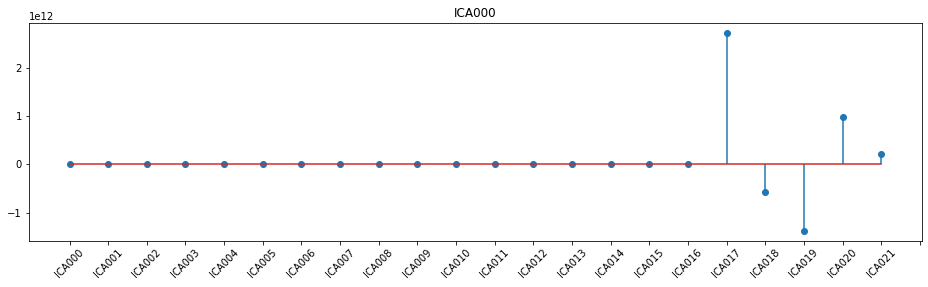

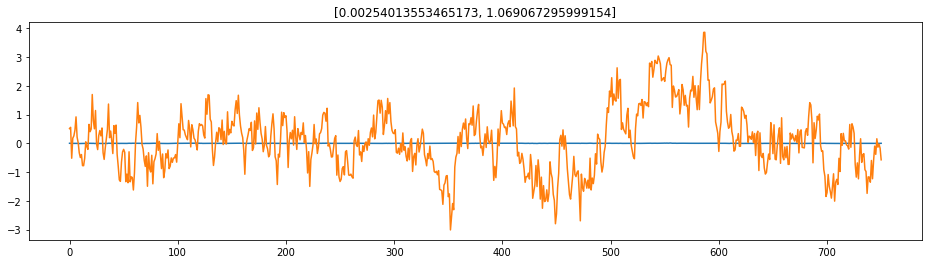

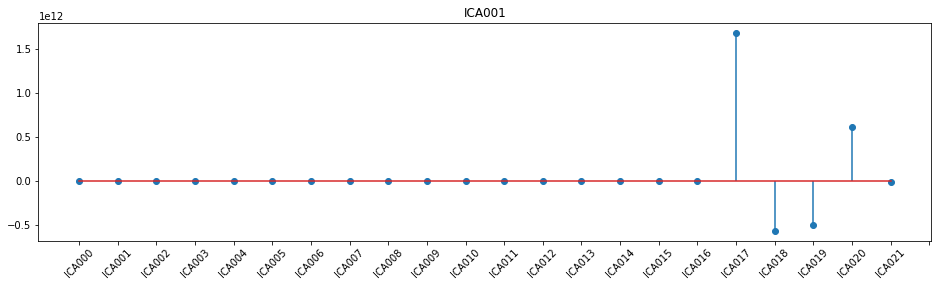

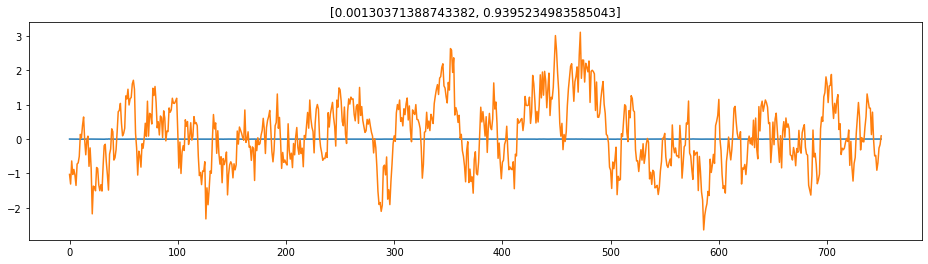

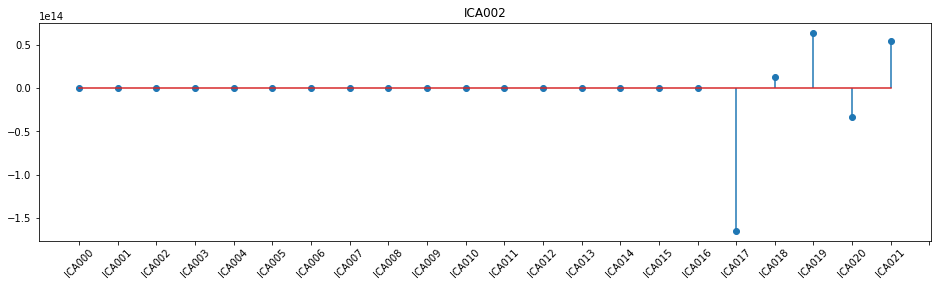

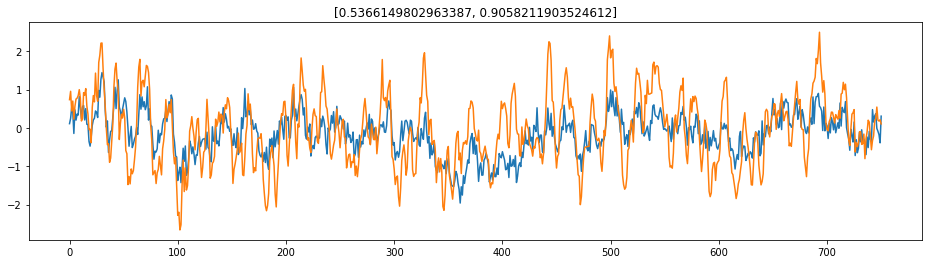

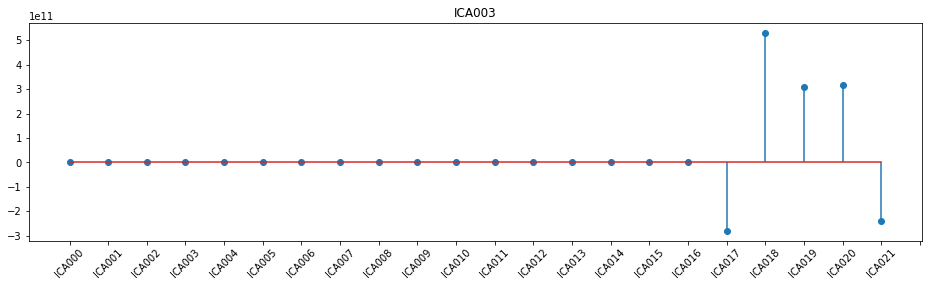

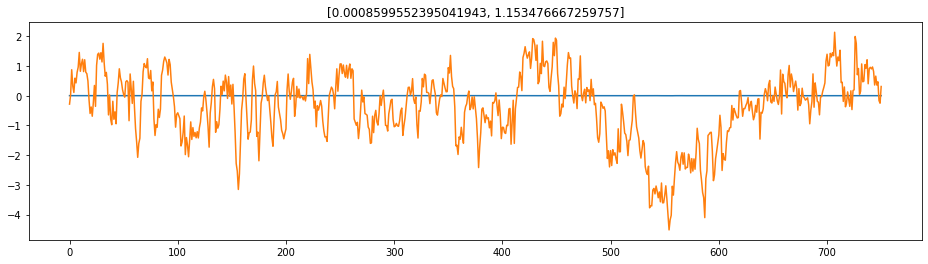

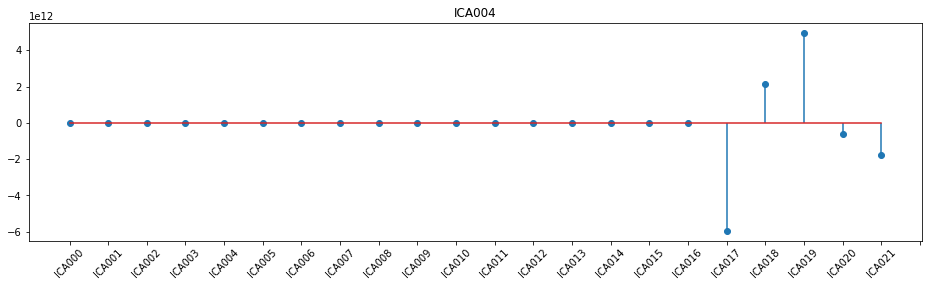

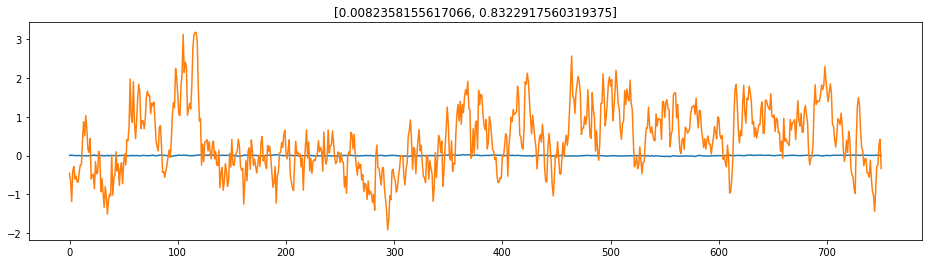

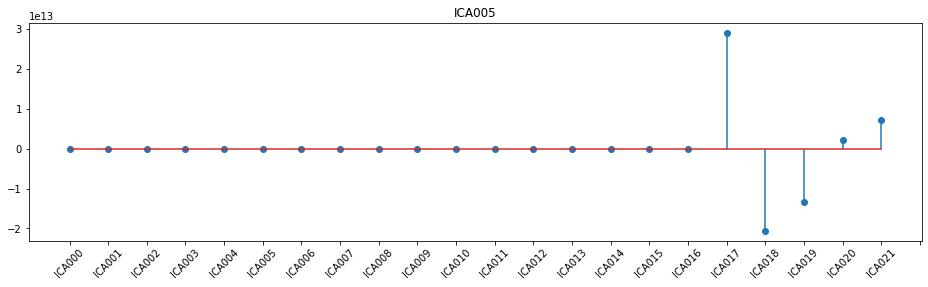

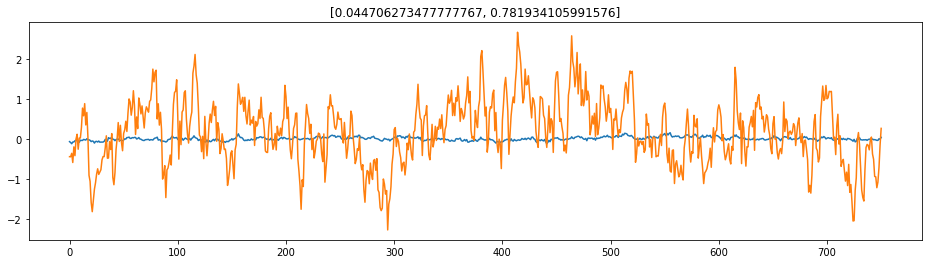

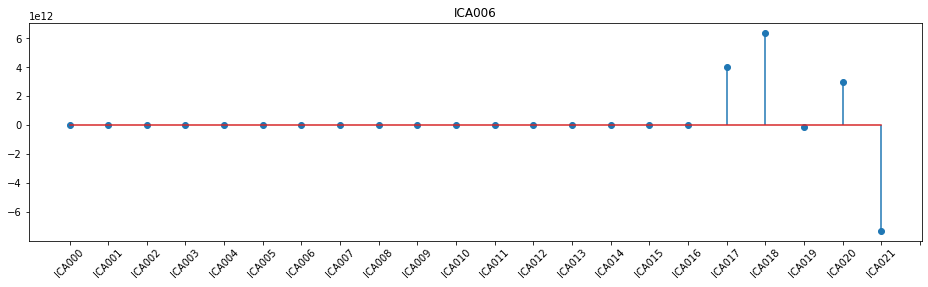

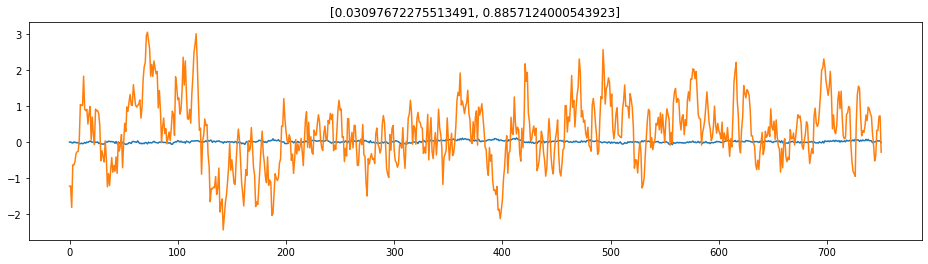

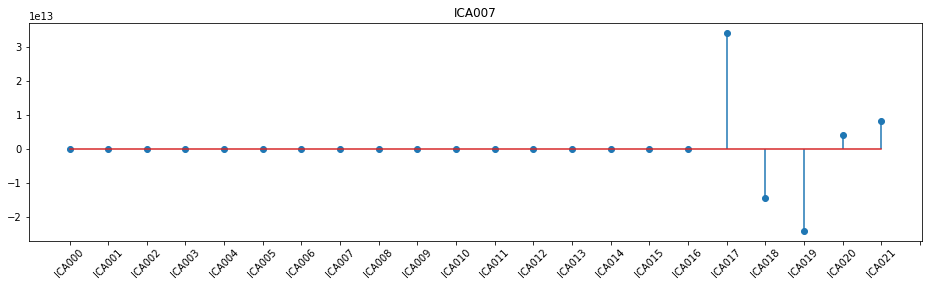

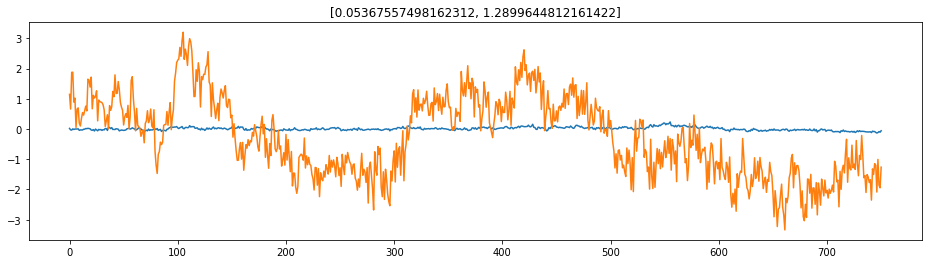

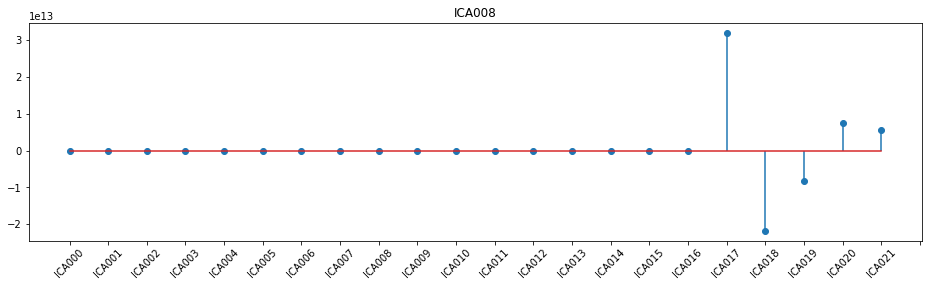

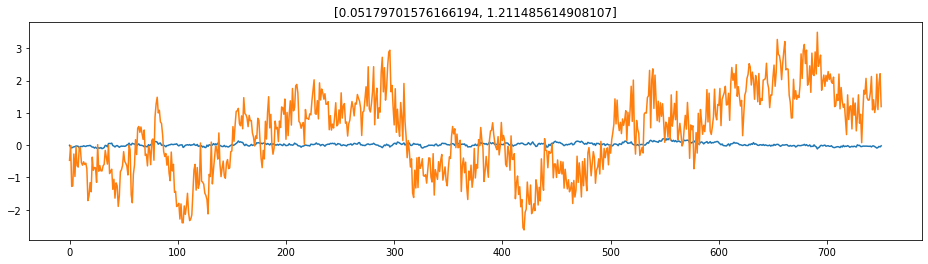

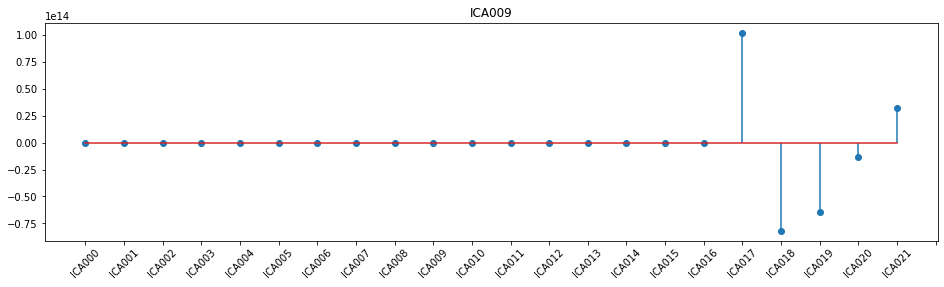

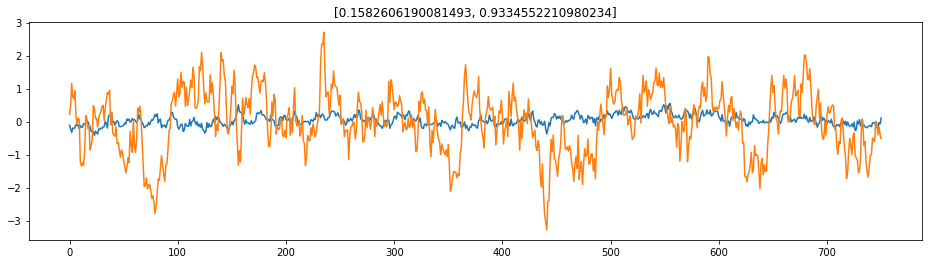

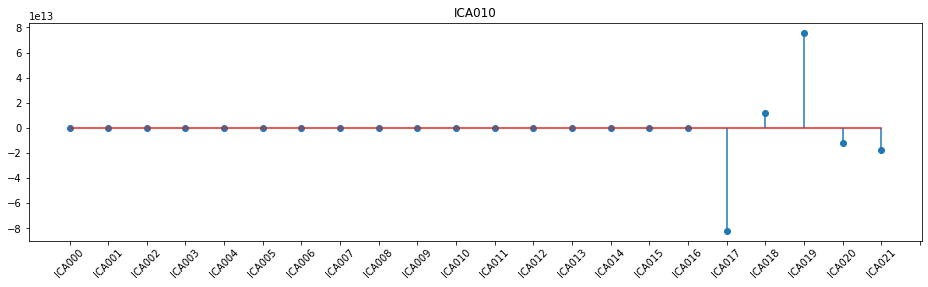

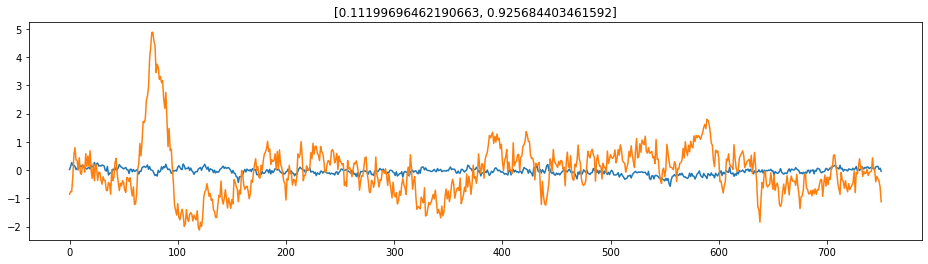

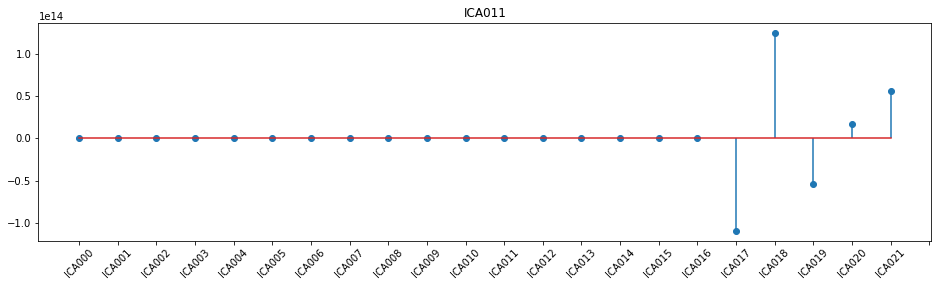

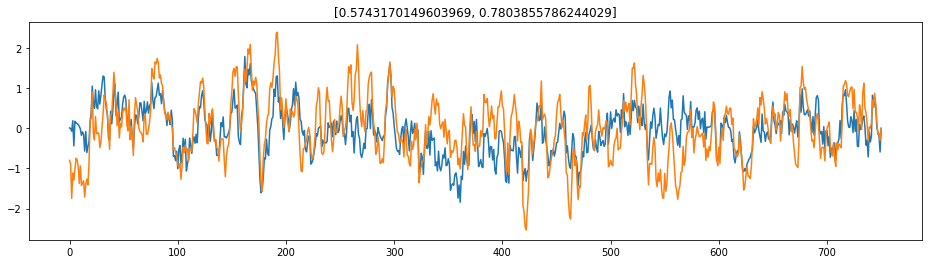

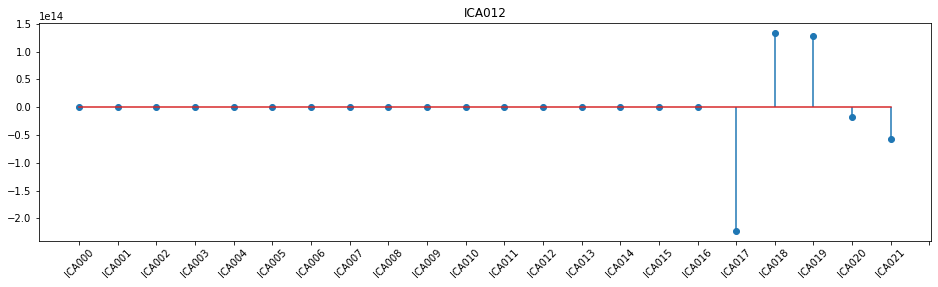

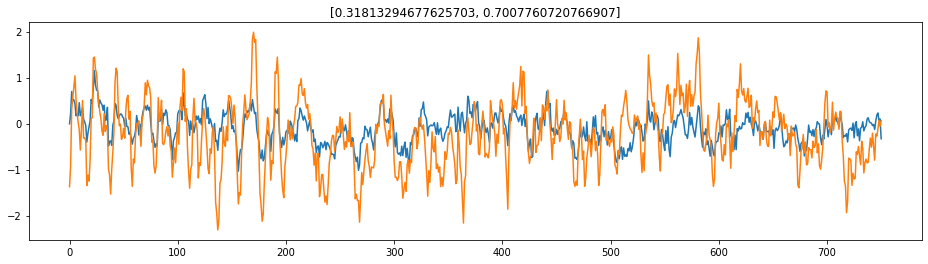

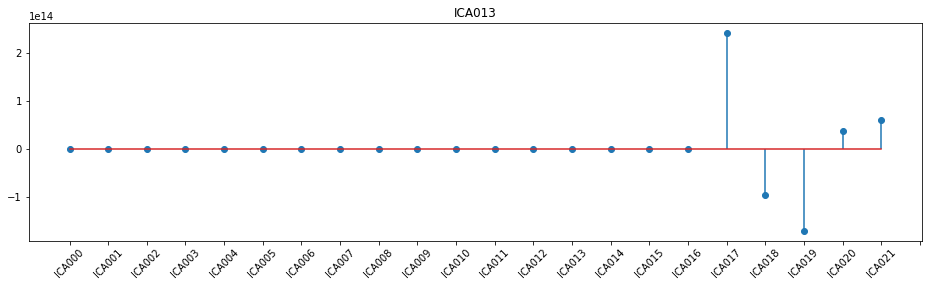

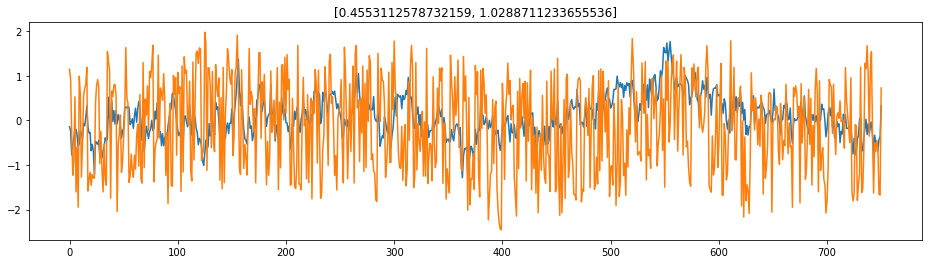

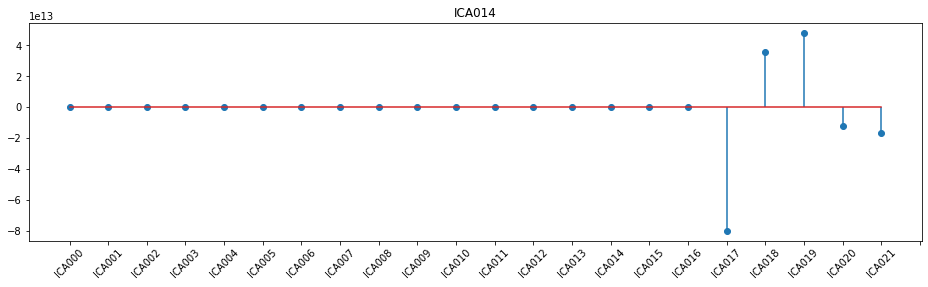

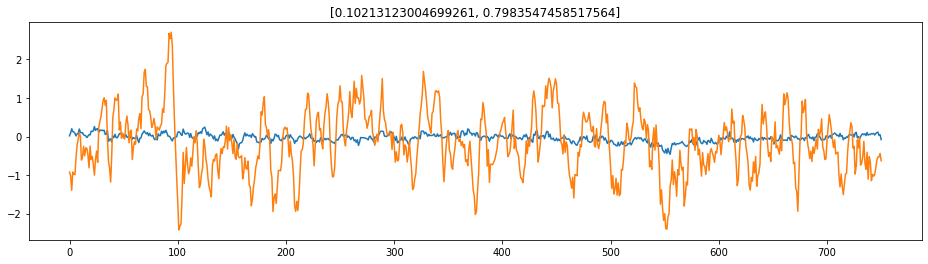

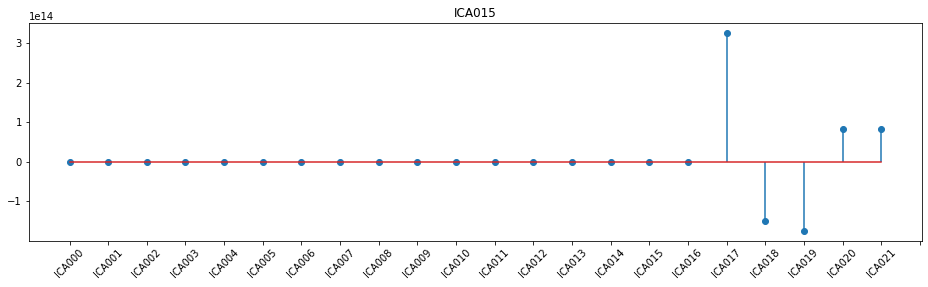

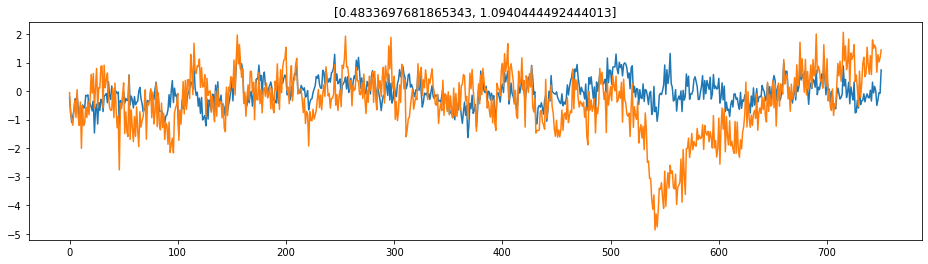

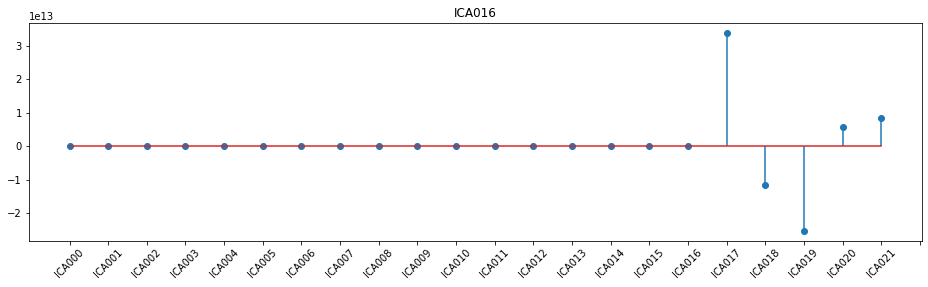

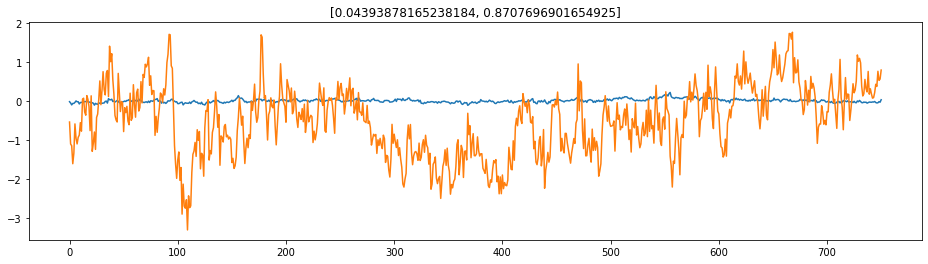

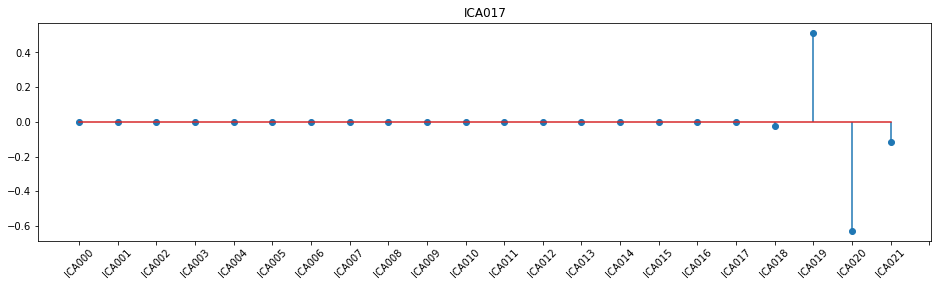

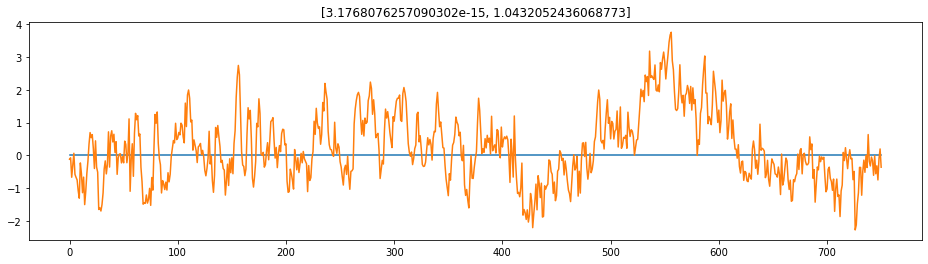

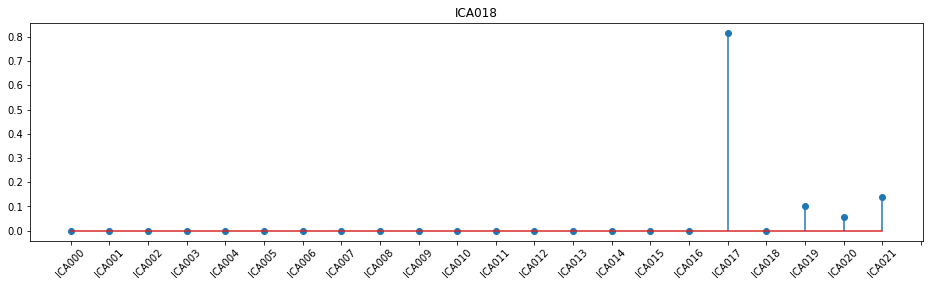

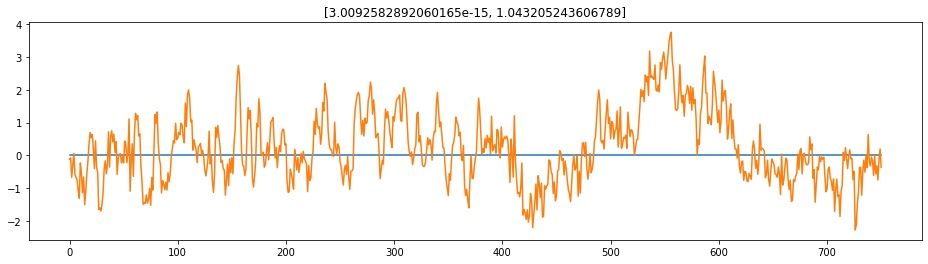

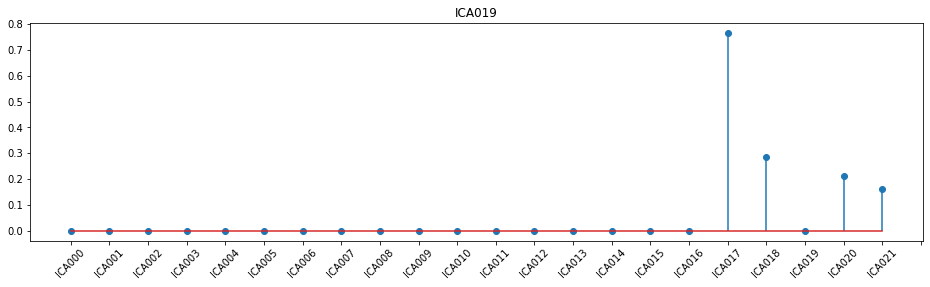

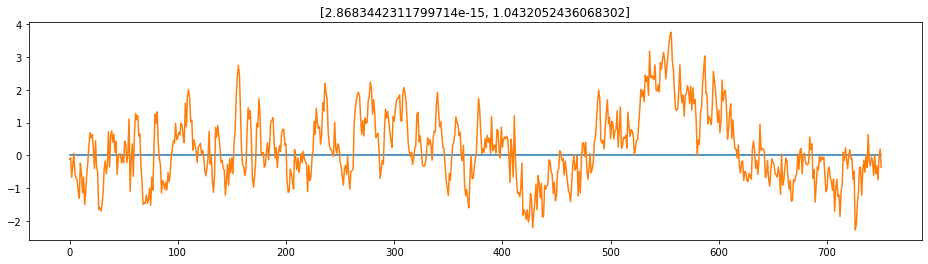

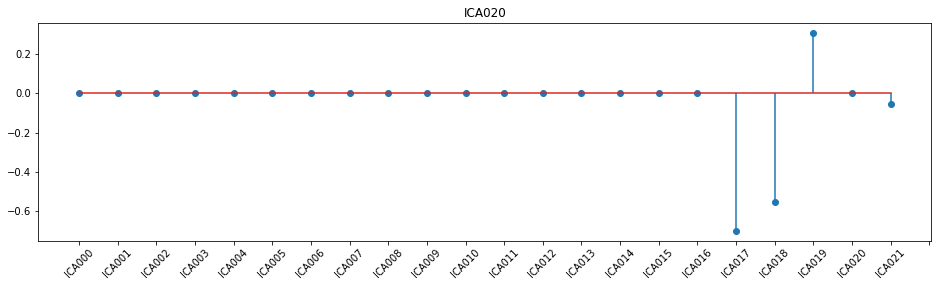

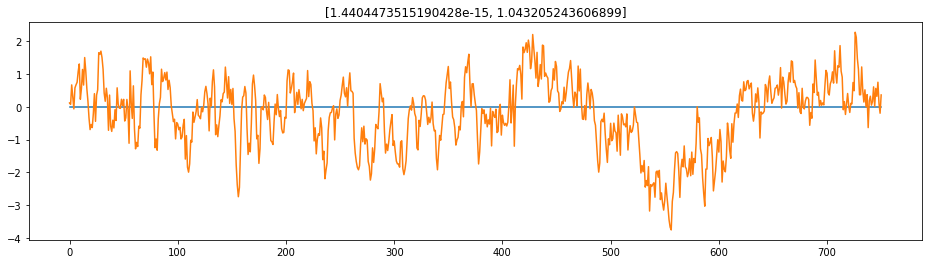

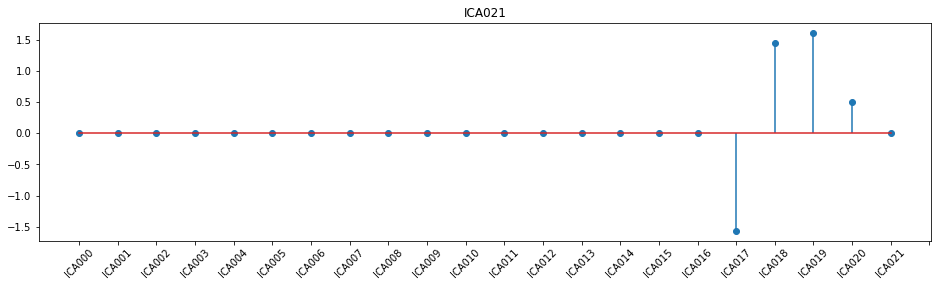

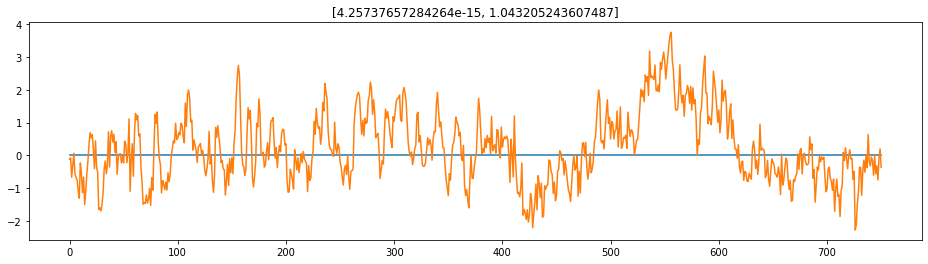

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

data = imagery_sources_epochs_list[0].copy().get_data()
ch_names = imagery_sources_epochs_list[0].ch_names
models = dict()
filtered_signals = dict()
for c_idx in range(22):
    
    x_channels = list(range(22))
    x_channels.remove(c_idx)
    olr = LinearRegression(fit_intercept=False)
    x = data[:, x_channels, :]
    y = data[:, [c_idx], :]
    x = x.transpose(1, 0, 2).reshape(21, -1).T
    y = y.transpose(1, 0, 2).reshape(1, -1).T
    olr.fit(x, y)
    pred = olr.predict(x)
    models[c_idx] = olr
    filtered_signals[c_idx] = y - pred
    print(ch_names[c_idx], r2_score(pred, y), mean_squared_error(pred, y))

for i in range(22):
    m = models[i]
    plt.figure(figsize=(16, 4))
    plt.title(ch_names[i])
    coefs = list(m.coef_.flatten())
    coefs = coefs[:i] + [0] + coefs[i:]
    plt.stem(ch_names, coefs)
    plt.xticks(range(23), rotation = 45) 

    plt.show()
    f = filtered_signals[i][:751]
    s = data[0, i, :]
    plt.figure(figsize=(16, 4))
    plt.title([f.std(), s.std()])
    plt.plot(f, label="Filtered")
    plt.plot(s, label="Signal")

#     plt.ylim(-5, 5)
    plt.show()


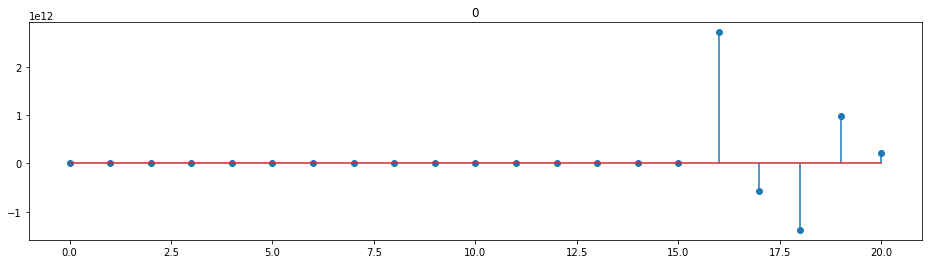

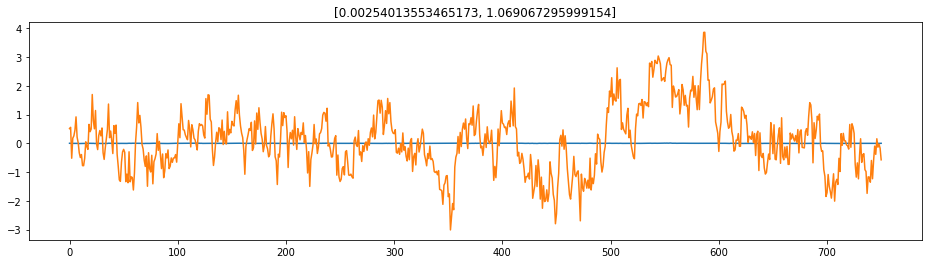

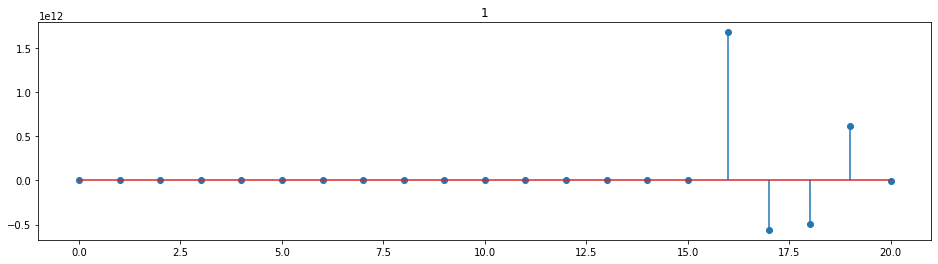

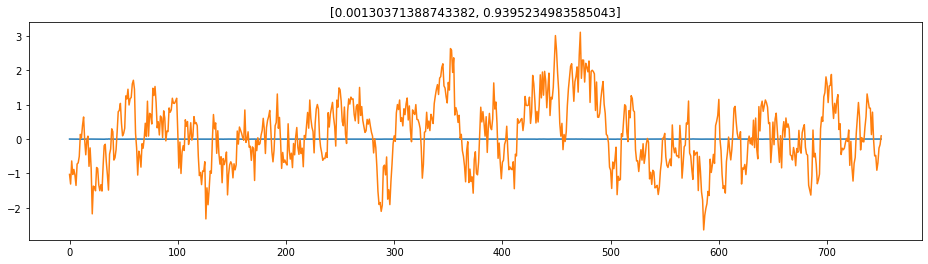

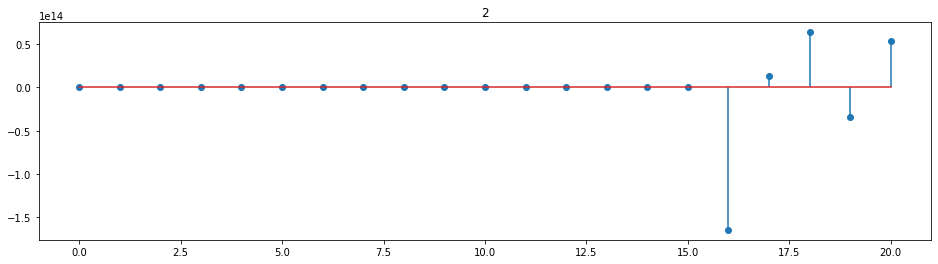

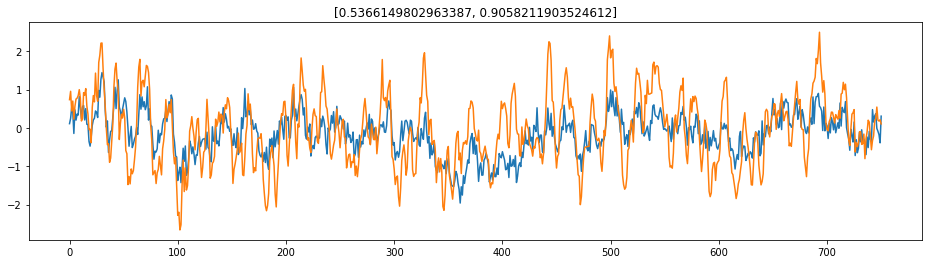

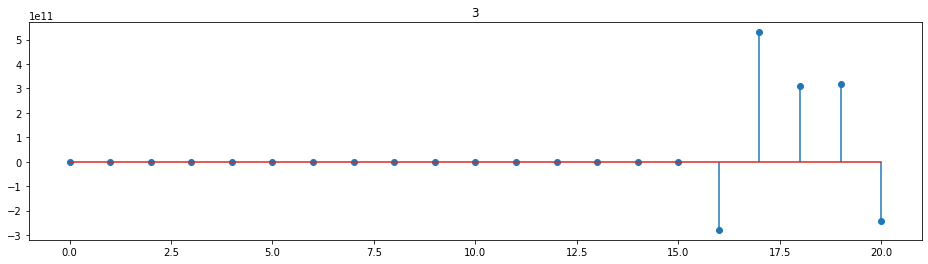

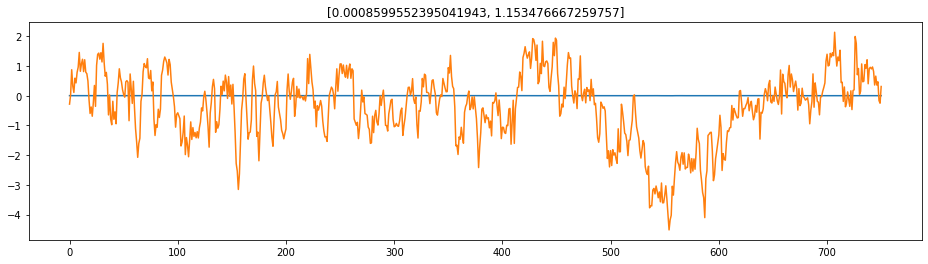

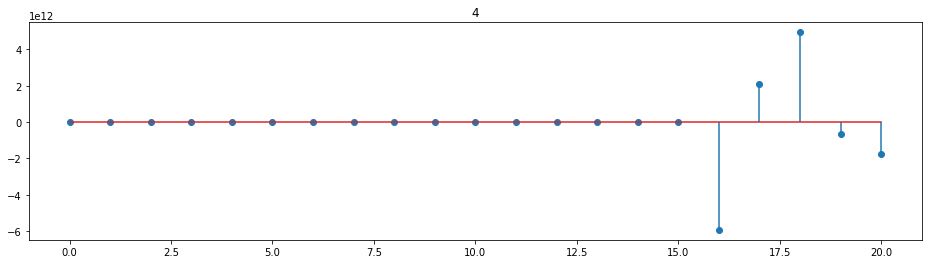

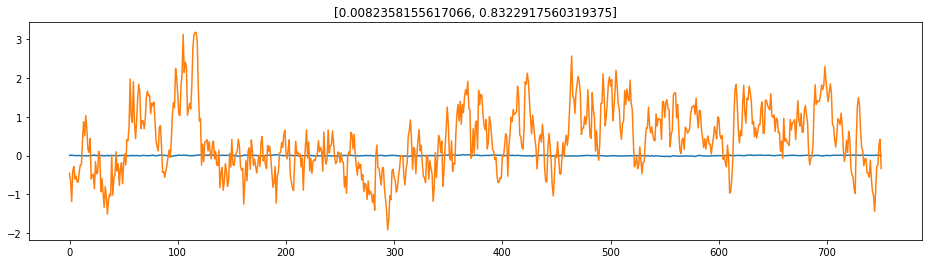

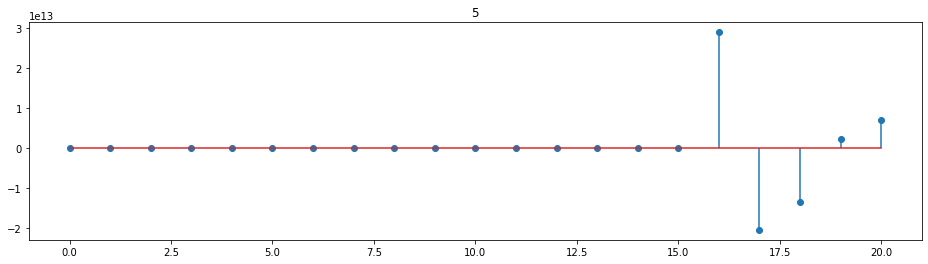

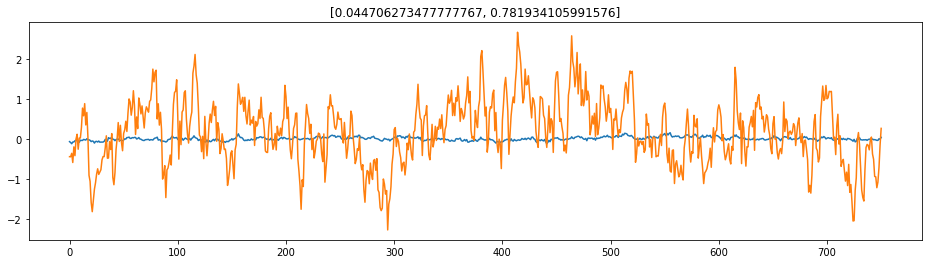

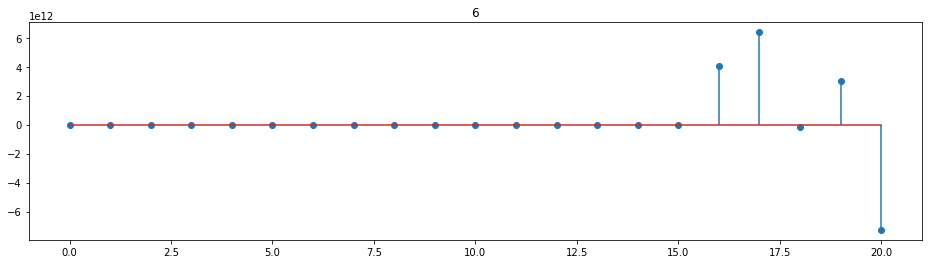

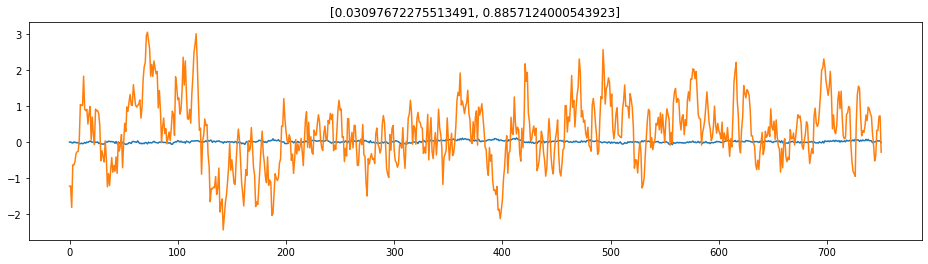

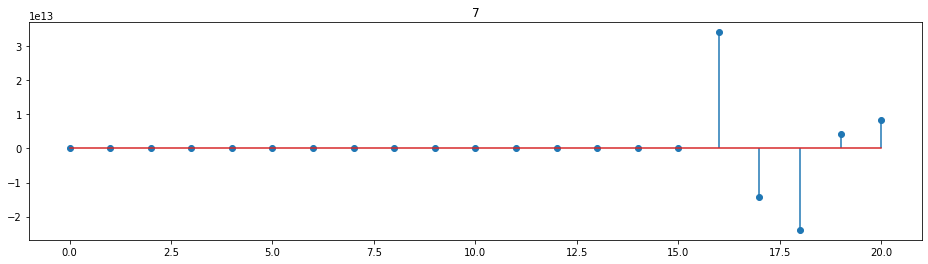

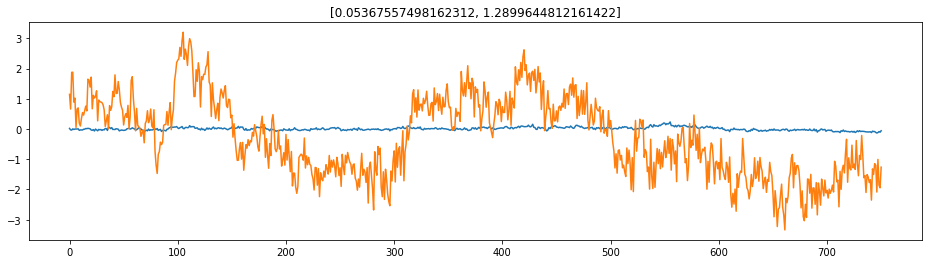

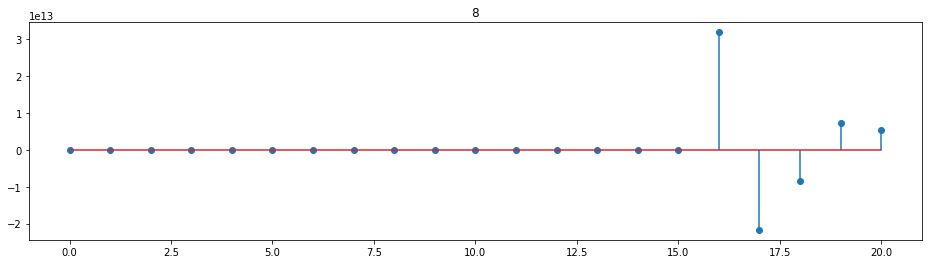

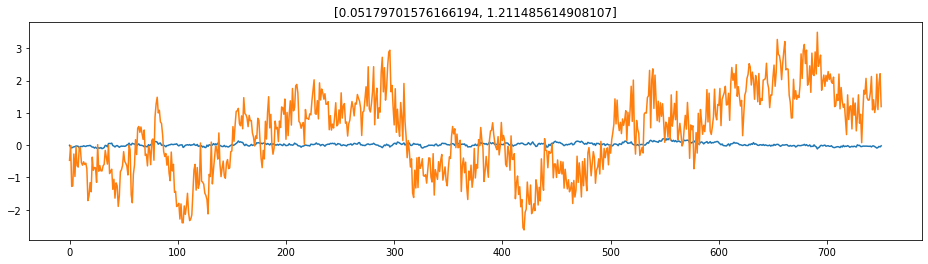

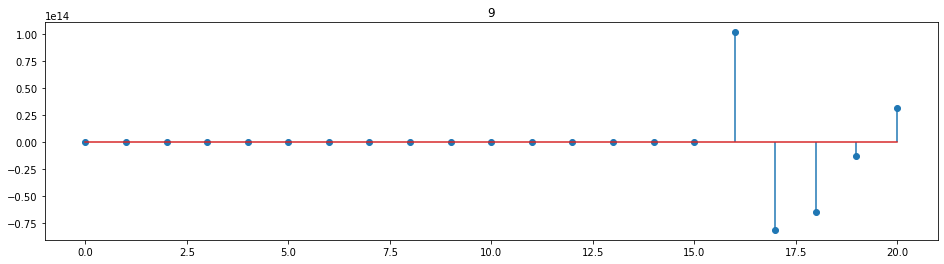

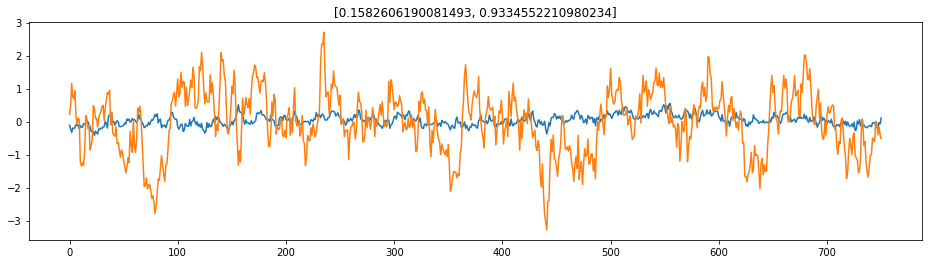

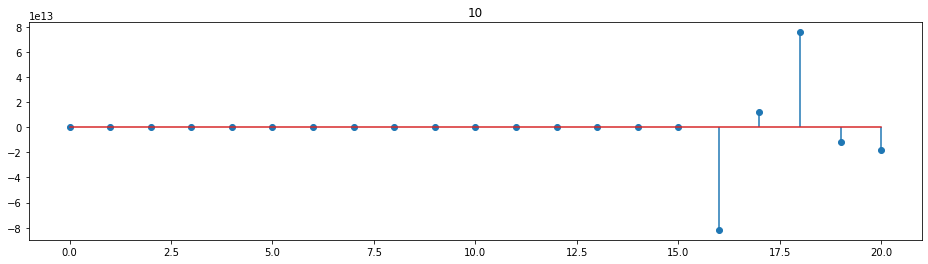

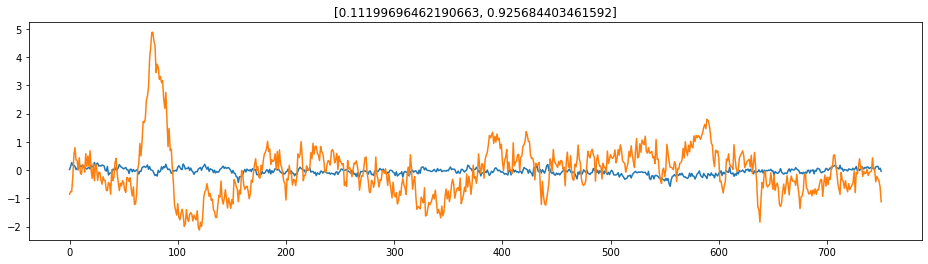

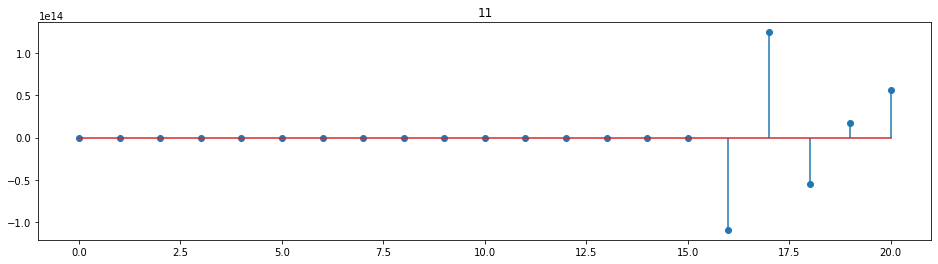

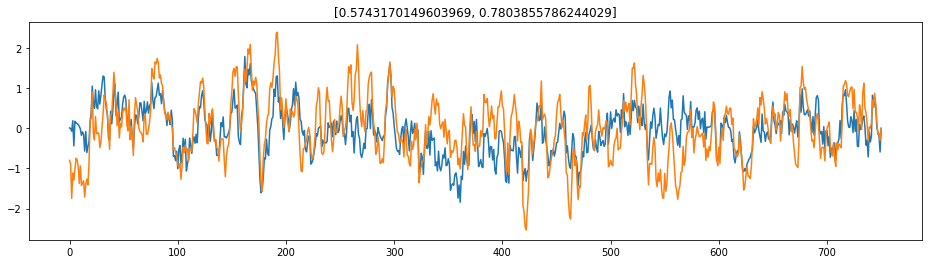

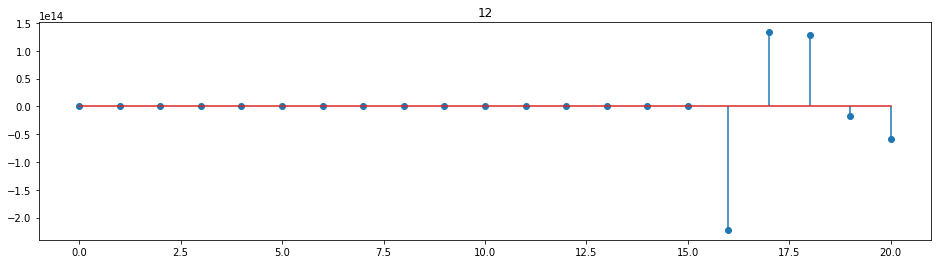

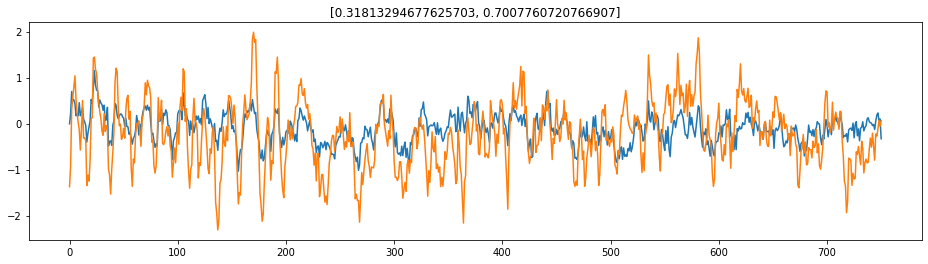

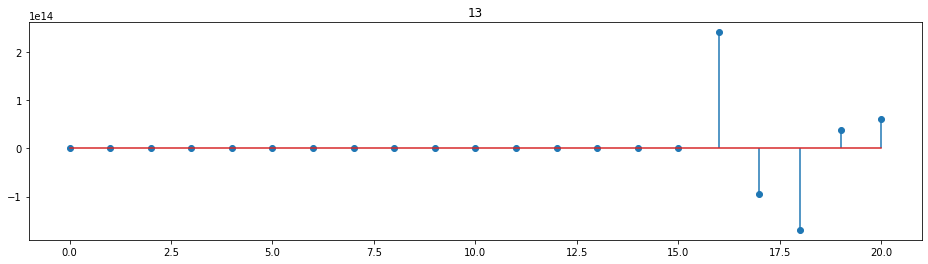

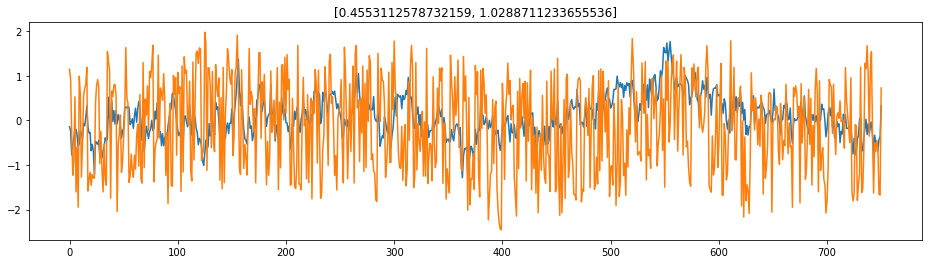

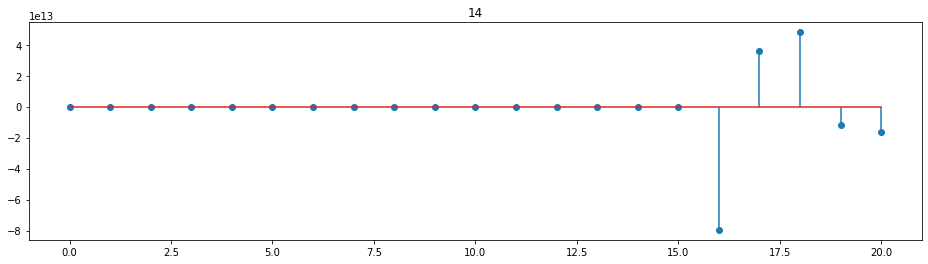

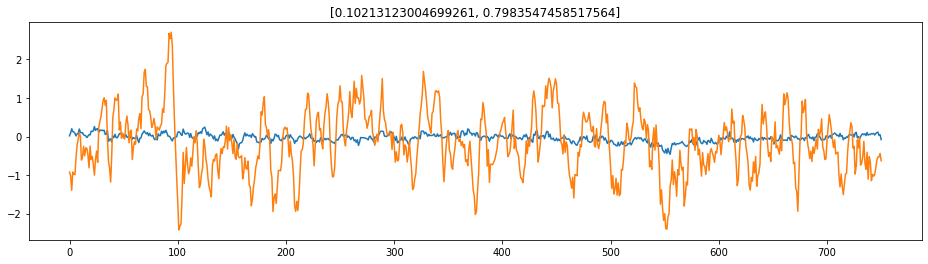

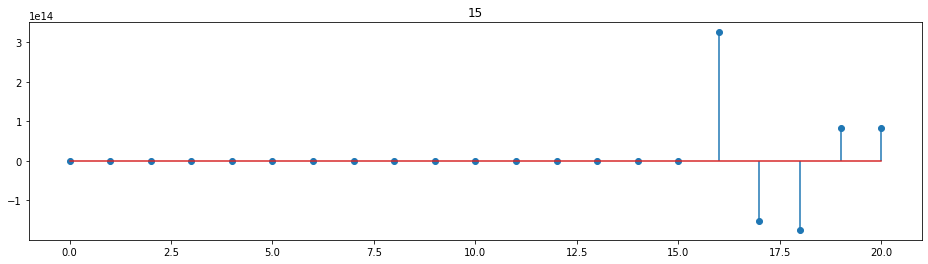

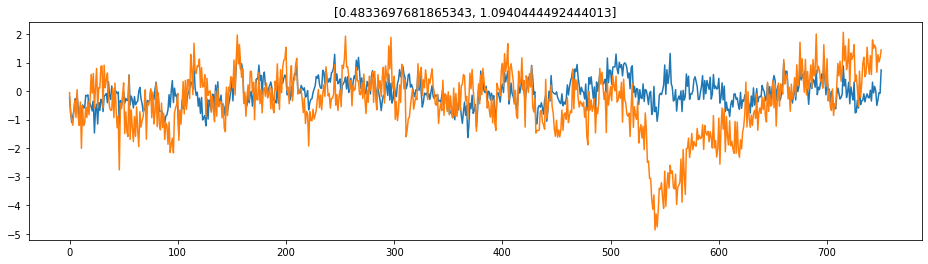

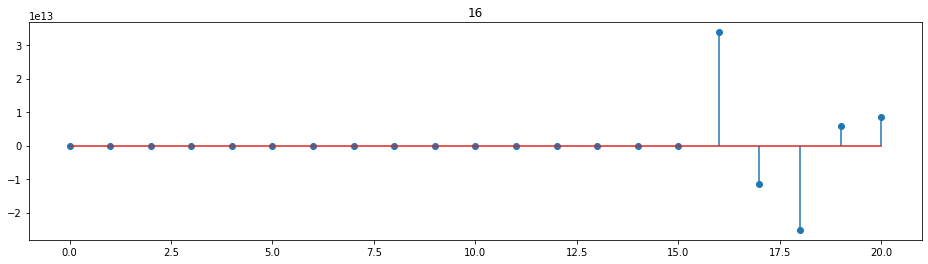

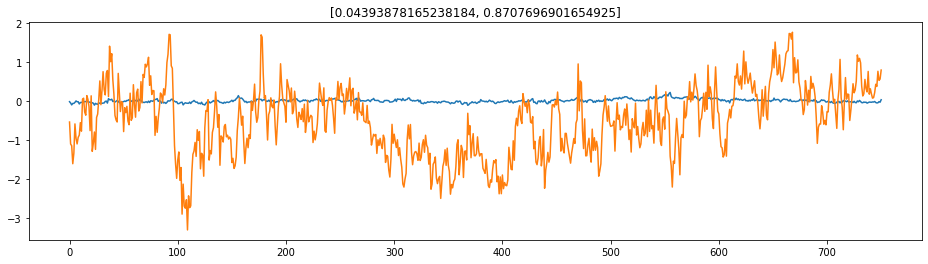

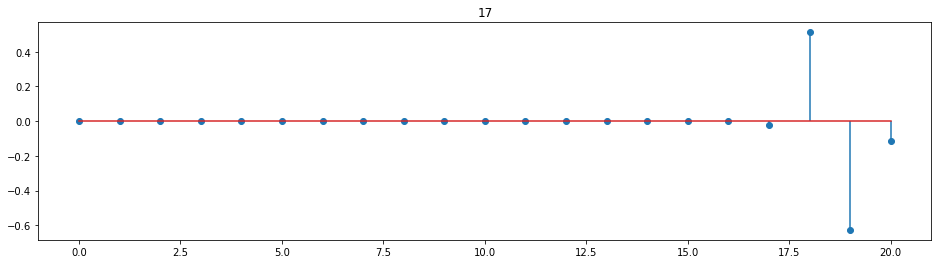

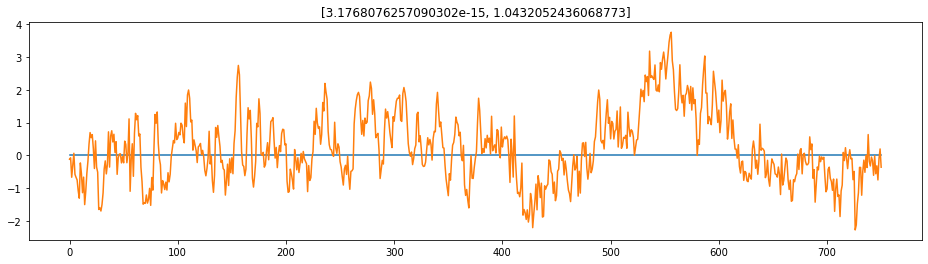

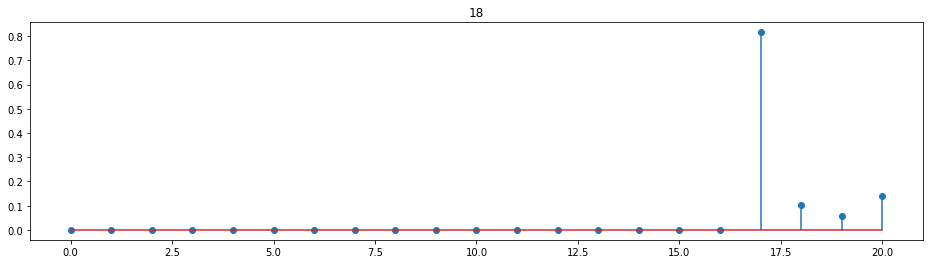

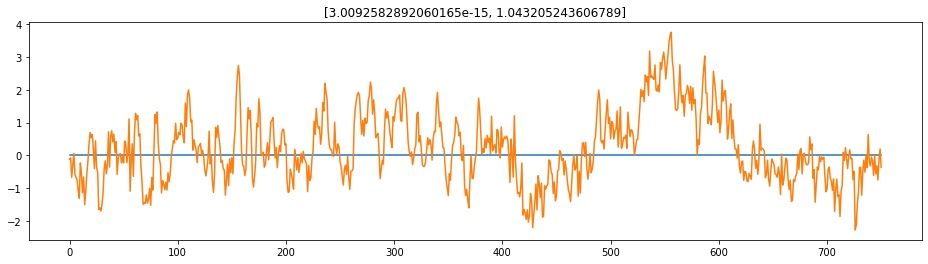

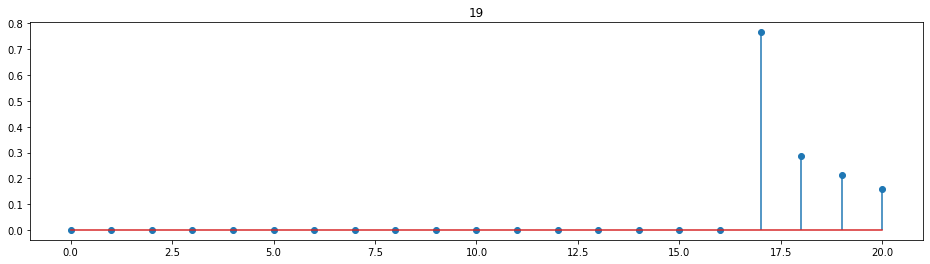

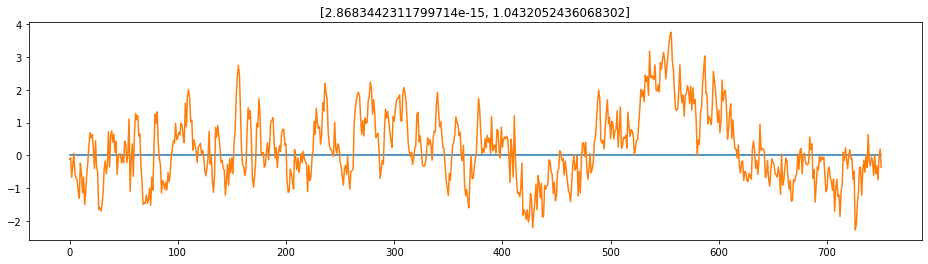

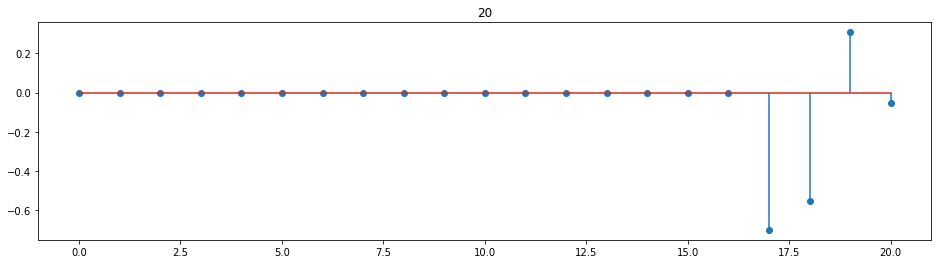

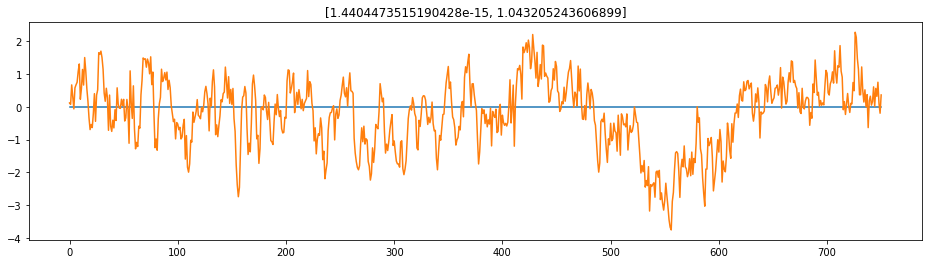

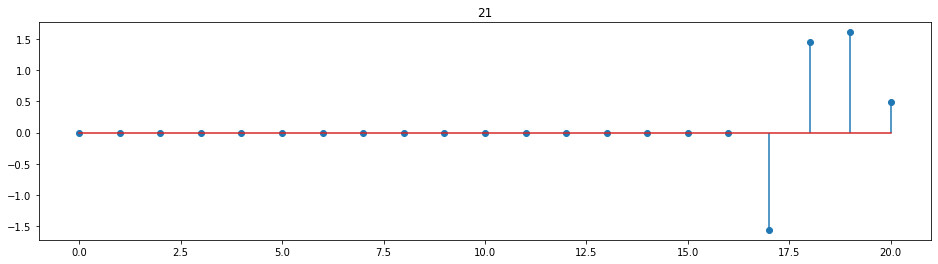

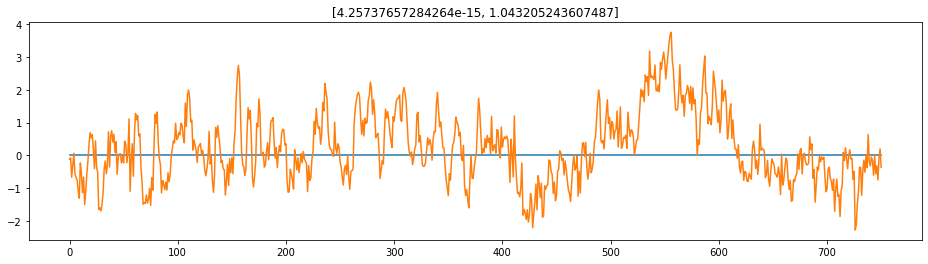

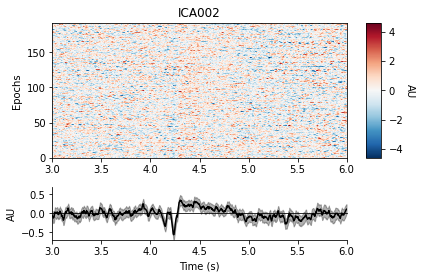

[<Figure size 432x288 with 3 Axes>]

In [21]:
mne.viz.plot_epochs_image(imagery_sources_epochs_list[0].copy(), picks="ICA002")

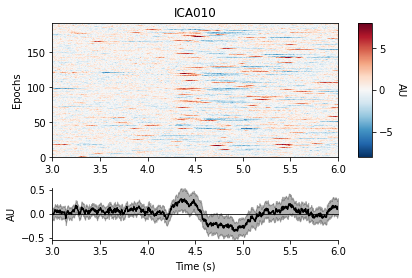

[<Figure size 432x288 with 3 Axes>]

In [16]:
mne.viz.plot_epochs_image(imagery_sources_epochs_list[0].copy(), picks="ICA010")

In [12]:
imagery_sources_epochs_list[0].copy()

<Epochs |  192 events (all good), 3 - 6 sec, baseline off, ~24.2 MB, data loaded,
 '0': 54
 '1': 50
 '2': 43
 '3': 45>

In [ ]:
x = np.random.gamma(size=10000, shape=1, scale=.2)
m = x.mean()
v = x.var()
print(v / m, m ** 2 / v)
plt.hist(x, bins=50)

In [ ]:
n_channels = len(selected_channels)
fig, axes = plt.subplots(n_channels, n_channels, figsize=(4 * n_channels, 6 * n_channels), dpi=120)
sequences = list()
for row, channel_1 in enumerate(selected_channels):
    for col, channel_2 in enumerate(selected_channels):
        if row > col:
            axes[row, col].axis(False)
            continue
        for cue in cues:
            epochs = [
                e \
                .copy() 
                for e in imagery_epochs_list
            ]
            crosscorr_sequence = multi_person_ccf_from_epochs(
                epochs,
                channel_1,
                channel_2,
                cue=cue,
                nlags=50
            )
            sequences.append(crosscorr_sequence)

        ax = axes[row, col]
        plot_cue_stems(
            sequences,
            orig_ax=ax,
            title="{} x {}".format(
                e_idx,
                channel_1,
                channel_2
            )
        )
plt.show()